In [4]:
import csv
import numpy as np
import Loader
import tensorflow as tf
import Transformer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

In [52]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)


labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  compoundDataTrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,9,4,6,7,3,16])

labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

#after transformations are done assign data
dataLabels = labelsMaxPCA
trainData = trainMaxPCA
testData = testMaxPCA
valData = valMaxPCA

trainData, testData, valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

print(np.shape(trainData))
for i in range(len(dataLabels)):
    print(i, "\b:\t", dataLabels[i], "\t", trainData[0:3,i])

bcut2d retention: [0.99364773]
	total: 99.36477273412339%
chi retention: [0.9541968]
	total: 95.41967968597889%
paoe retention: [0.31495127 0.19509321 0.1390042  0.08838179 0.07155396 0.04590061
 0.03243    0.02673268 0.02402293]
	total: 93.80706737004664%
smr retention: [0.50634726 0.24568468 0.08792319 0.07435827]
	total: 91.43133907840055%
slogp retention: [0.44620276 0.22134465 0.15753302 0.04213752 0.03159298 0.02850562]
	total: 92.73165471968964%
estate_vsa retention: [0.29224011 0.18964809 0.14361318 0.10642656 0.07394495 0.06391846
 0.05513575]
	total: 92.49271047439836%
vsa_estate retention: [0.49255304 0.32866098 0.09719245]
	total: 91.84064669216805%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485  0.05494644 0.04503917
 0.03646285 0.02896244 0.02597271 0.02289905 0.01957315 0.01726897
 0.01514304 0.01174712 0.01137901 0.00991608]
	total: 90.31191273351006%
(2717, 95)
0 :	 docking_score_max 	 [5.41373656e-01 4.33138761e-01 1.99180889e-04]
1 :	 fusion_score_max 	 

In [9]:
classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)
inputDim = len(dataLabels)


l1Reg = keras.regularizers.L1(.001)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

historys = []
dataPercents = [0.9,.8,.7,.6,.5,.4,.3,.2,.1]
for percent in dataPercents:
    
    model1 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(2)
    ])

    model1.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

    (Xtrain,_,Ytrain,_) = model_selection.train_test_split(trainData, classTrain, test_size=(1 - percent))
    print("Percent: ", percent, ". Actual shape: ", np.shape(Xtrain))
    historys.append( model1.fit(Xtrain, Ytrain, validation_data = (valData, classVal), epochs=100, batch_size=4) )

Percent:  0.9 . Actual shape:  (2445, 95)
Epoch 1/100
612/612 [==============================] - 3s 4ms/step - loss: 2.5782 - accuracy: 0.8258 - val_loss: 1.0061 - val_accuracy: 0.8529
Epoch 2/100
612/612 [==============================] - 2s 3ms/step - loss: 0.7698 - accuracy: 0.8896 - val_loss: 0.6836 - val_accuracy: 0.8676
Epoch 3/100
612/612 [==============================] - 2s 3ms/step - loss: 0.5803 - accuracy: 0.8986 - val_loss: 0.5356 - val_accuracy: 0.9000
Epoch 4/100
612/612 [==============================] - 2s 3ms/step - loss: 0.4917 - accuracy: 0.9100 - val_loss: 0.5548 - val_accuracy: 0.8735
Epoch 5/100
612/612 [==============================] - 2s 3ms/step - loss: 0.4478 - accuracy: 0.9178 - val_loss: 0.5009 - val_accuracy: 0.8853
Epoch 6/100
612/612 [==============================] - 2s 3ms/step - loss: 0.4088 - accuracy: 0.9256 - val_loss: 0.5117 - val_accuracy: 0.8559
Epoch 7/100
612/612 [==============================] - 2s 3ms/step - loss: 0.3819 - accuracy: 0.9309

Epoch 14/100
544/544 [==============================] - 2s 3ms/step - loss: 0.2605 - accuracy: 0.9508 - val_loss: 0.4212 - val_accuracy: 0.9000
Epoch 15/100
544/544 [==============================] - 1s 3ms/step - loss: 0.2583 - accuracy: 0.9494 - val_loss: 0.3961 - val_accuracy: 0.9059
Epoch 16/100
544/544 [==============================] - 2s 3ms/step - loss: 0.2597 - accuracy: 0.9535 - val_loss: 0.3922 - val_accuracy: 0.9029
Epoch 17/100
544/544 [==============================] - 1s 2ms/step - loss: 0.2571 - accuracy: 0.9526 - val_loss: 0.3897 - val_accuracy: 0.9059
Epoch 18/100
544/544 [==============================] - 1s 3ms/step - loss: 0.2438 - accuracy: 0.9572 - val_loss: 0.3887 - val_accuracy: 0.9088
Epoch 19/100
544/544 [==============================] - 2s 3ms/step - loss: 0.2442 - accuracy: 0.9567 - val_loss: 0.4212 - val_accuracy: 0.8971
Epoch 20/100
544/544 [==============================] - 1s 3ms/step - loss: 0.2350 - accuracy: 0.9636 - val_loss: 0.4167 - val_accuracy:

Epoch 71/100
544/544 [==============================] - 1s 3ms/step - loss: 0.1781 - accuracy: 0.9839 - val_loss: 0.4500 - val_accuracy: 0.9265
Epoch 72/100
544/544 [==============================] - 2s 3ms/step - loss: 0.2135 - accuracy: 0.9715 - val_loss: 0.4092 - val_accuracy: 0.9118
Epoch 73/100
544/544 [==============================] - 1s 3ms/step - loss: 0.1897 - accuracy: 0.9788 - val_loss: 0.4091 - val_accuracy: 0.9176
Epoch 74/100
544/544 [==============================] - 1s 3ms/step - loss: 0.1778 - accuracy: 0.9839 - val_loss: 0.4484 - val_accuracy: 0.9176
Epoch 75/100
544/544 [==============================] - 2s 3ms/step - loss: 0.2150 - accuracy: 0.9705 - val_loss: 0.4941 - val_accuracy: 0.9000
Epoch 76/100
544/544 [==============================] - 2s 3ms/step - loss: 0.1886 - accuracy: 0.9816 - val_loss: 0.4706 - val_accuracy: 0.9059
Epoch 77/100
544/544 [==============================] - 1s 3ms/step - loss: 0.1976 - accuracy: 0.9724 - val_loss: 0.4478 - val_accuracy:

Epoch 84/100
476/476 [==============================] - 1s 3ms/step - loss: 0.2145 - accuracy: 0.9695 - val_loss: 0.4752 - val_accuracy: 0.9000
Epoch 85/100
476/476 [==============================] - 1s 3ms/step - loss: 0.1935 - accuracy: 0.9748 - val_loss: 0.4830 - val_accuracy: 0.8971
Epoch 86/100
476/476 [==============================] - 1s 3ms/step - loss: 0.1841 - accuracy: 0.9795 - val_loss: 0.6118 - val_accuracy: 0.8882
Epoch 87/100
476/476 [==============================] - 1s 3ms/step - loss: 0.2391 - accuracy: 0.9590 - val_loss: 0.4234 - val_accuracy: 0.9029
Epoch 88/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2048 - accuracy: 0.9742 - val_loss: 0.4056 - val_accuracy: 0.9029
Epoch 89/100
476/476 [==============================] - 1s 3ms/step - loss: 0.2026 - accuracy: 0.9711 - val_loss: 0.4393 - val_accuracy: 0.9118
Epoch 90/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1913 - accuracy: 0.9774 - val_loss: 0.4259 - val_accuracy:

Epoch 97/100
408/408 [==============================] - 2s 5ms/step - loss: 0.6783 - accuracy: 0.6294 - val_loss: 0.6875 - val_accuracy: 0.6118
Epoch 98/100
408/408 [==============================] - 3s 7ms/step - loss: 0.6785 - accuracy: 0.6294 - val_loss: 0.6873 - val_accuracy: 0.6118
Epoch 99/100
408/408 [==============================] - 3s 7ms/step - loss: 0.6784 - accuracy: 0.6294 - val_loss: 0.6873 - val_accuracy: 0.6118
Epoch 100/100
408/408 [==============================] - 2s 6ms/step - loss: 0.6785 - accuracy: 0.6294 - val_loss: 0.6874 - val_accuracy: 0.6118
Percent:  0.5 . Actual shape:  (1358, 95)
Epoch 1/100
340/340 [==============================] - 3s 5ms/step - loss: 1.6160 - accuracy: 0.7938 - val_loss: 0.6600 - val_accuracy: 0.8676
Epoch 2/100
340/340 [==============================] - 2s 7ms/step - loss: 0.5695 - accuracy: 0.8807 - val_loss: 0.5516 - val_accuracy: 0.8647
Epoch 3/100
340/340 [==============================] - 2s 6ms/step - loss: 0.4766 - accuracy: 0

Epoch 10/100
272/272 [==============================] - 2s 8ms/step - loss: 0.6871 - accuracy: 0.6142 - val_loss: 0.6878 - val_accuracy: 0.6118
Epoch 11/100
272/272 [==============================] - 1s 5ms/step - loss: 0.6870 - accuracy: 0.6142 - val_loss: 0.6875 - val_accuracy: 0.6118
Epoch 12/100
272/272 [==============================] - 2s 8ms/step - loss: 0.6866 - accuracy: 0.6142 - val_loss: 0.6874 - val_accuracy: 0.6118
Epoch 13/100
272/272 [==============================] - 1s 5ms/step - loss: 0.6868 - accuracy: 0.6142 - val_loss: 0.6872 - val_accuracy: 0.6118
Epoch 14/100
272/272 [==============================] - 2s 7ms/step - loss: 0.6864 - accuracy: 0.6142 - val_loss: 0.6873 - val_accuracy: 0.6118
Epoch 15/100
272/272 [==============================] - 2s 8ms/step - loss: 0.6866 - accuracy: 0.6142 - val_loss: 0.6871 - val_accuracy: 0.6118
Epoch 16/100
272/272 [==============================] - 2s 7ms/step - loss: 0.6865 - accuracy: 0.6142 - val_loss: 0.6870 - val_accuracy:

Epoch 67/100
272/272 [==============================] - 2s 8ms/step - loss: 0.6862 - accuracy: 0.6142 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 68/100
272/272 [==============================] - 2s 8ms/step - loss: 0.6862 - accuracy: 0.6142 - val_loss: 0.6870 - val_accuracy: 0.6118
Epoch 69/100
272/272 [==============================] - 2s 6ms/step - loss: 0.6863 - accuracy: 0.6142 - val_loss: 0.6870 - val_accuracy: 0.6118
Epoch 70/100
272/272 [==============================] - 2s 8ms/step - loss: 0.6861 - accuracy: 0.6142 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 71/100
272/272 [==============================] - 2s 7ms/step - loss: 0.6862 - accuracy: 0.6142 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 72/100
272/272 [==============================] - 2s 7ms/step - loss: 0.6861 - accuracy: 0.6142 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 73/100
272/272 [==============================] - 1s 5ms/step - loss: 0.6862 - accuracy: 0.6142 - val_loss: 0.6869 - val_accuracy:

Epoch 80/100
204/204 [==============================] - 1s 7ms/step - loss: 0.2818 - accuracy: 0.9264 - val_loss: 0.5110 - val_accuracy: 0.8676
Epoch 81/100
204/204 [==============================] - 2s 9ms/step - loss: 0.2324 - accuracy: 0.9509 - val_loss: 0.5842 - val_accuracy: 0.8765
Epoch 82/100
204/204 [==============================] - 2s 8ms/step - loss: 0.2231 - accuracy: 0.9583 - val_loss: 0.5477 - val_accuracy: 0.8735
Epoch 83/100
204/204 [==============================] - 1s 7ms/step - loss: 0.2100 - accuracy: 0.9620 - val_loss: 0.5444 - val_accuracy: 0.8765
Epoch 84/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2029 - accuracy: 0.9656 - val_loss: 0.5281 - val_accuracy: 0.8765
Epoch 85/100
204/204 [==============================] - 2s 7ms/step - loss: 0.1999 - accuracy: 0.9656 - val_loss: 0.5472 - val_accuracy: 0.8824
Epoch 86/100
204/204 [==============================] - 1s 5ms/step - loss: 0.1982 - accuracy: 0.9656 - val_loss: 0.5389 - val_accuracy:

Epoch 93/100
136/136 [==============================] - 1s 8ms/step - loss: 0.6886 - accuracy: 0.6077 - val_loss: 0.6865 - val_accuracy: 0.6118
Epoch 94/100
136/136 [==============================] - 1s 8ms/step - loss: 0.6888 - accuracy: 0.6077 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 95/100
136/136 [==============================] - 1s 8ms/step - loss: 0.6888 - accuracy: 0.6077 - val_loss: 0.6865 - val_accuracy: 0.6118
Epoch 96/100
136/136 [==============================] - 1s 8ms/step - loss: 0.6886 - accuracy: 0.6077 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 97/100
136/136 [==============================] - 1s 8ms/step - loss: 0.6886 - accuracy: 0.6077 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 98/100
136/136 [==============================] - 1s 8ms/step - loss: 0.6888 - accuracy: 0.6077 - val_loss: 0.6865 - val_accuracy: 0.6118
Epoch 99/100
136/136 [==============================] - 1s 8ms/step - loss: 0.6887 - accuracy: 0.6077 - val_loss: 0.6865 - val_accuracy:

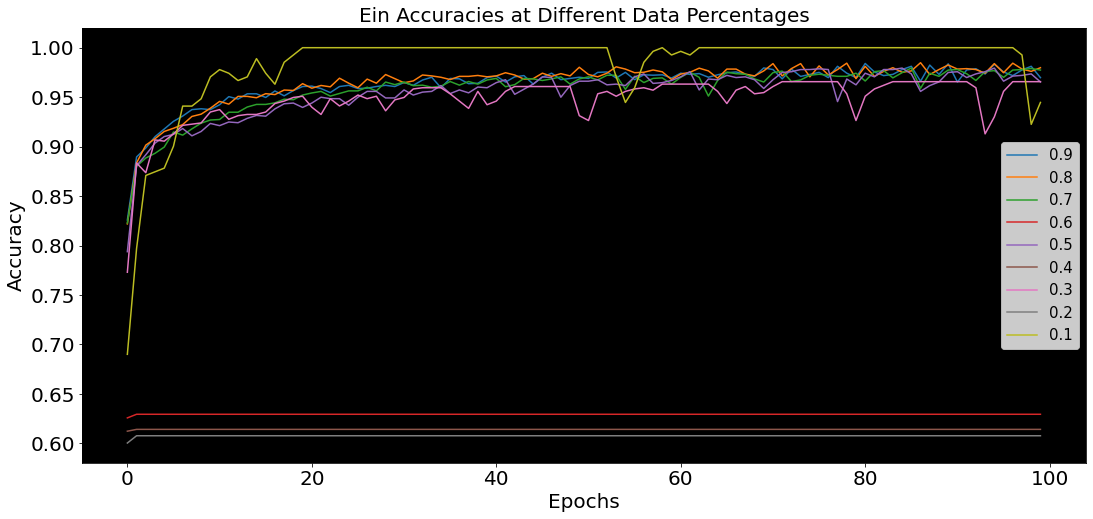

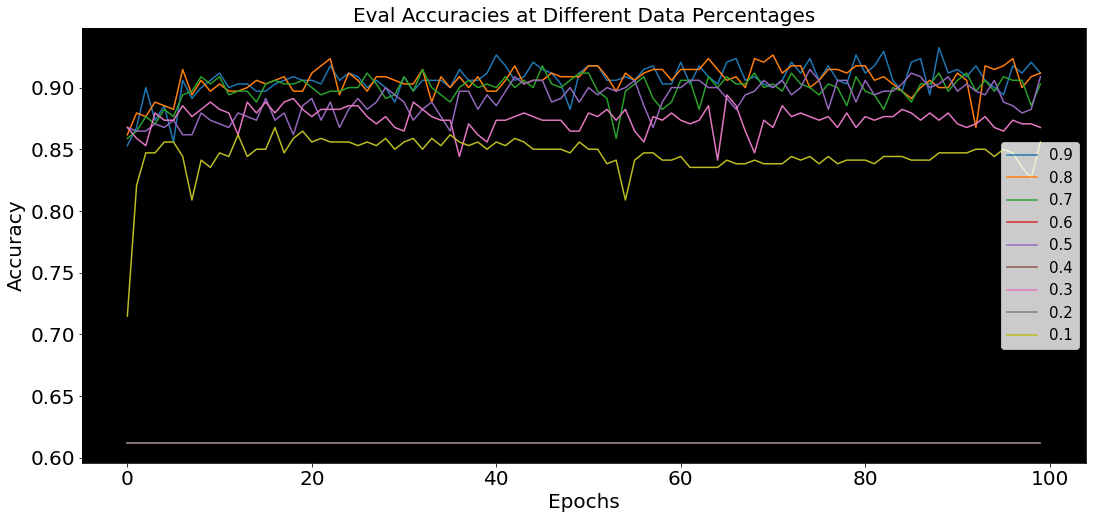

In [33]:

fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
fig1, ax1 = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i in range(len(historys)):    
    ax.plot(historys[i].history["accuracy"], label = dataPercents[i])
    ax1.plot(historys[i].history["val_accuracy"], label = dataPercents[i])
    
    
ax.legend(loc = 'right', fontsize = 15)
ax.set_title("Ein Accuracies at Different Data Percentages", fontsize = 20)
ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_facecolor("black")
ax1.legend(loc = 'right', fontsize = 15)
ax1.set_title("Eval Accuracies at Different Data Percentages", fontsize = 20)
ax1.set_xlabel("Epochs", fontsize = 20)
ax1.set_ylabel("Accuracy", fontsize = 20)
ax1.set_facecolor("black")

In [53]:
classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)
inputDim = len(dataLabels)


l1Reg = keras.regularizers.L1(.001)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

historys = []
dataPercents = [1,.9,.8,.7,.6,.5,.4,.3,.2,.1]

for percent in dataPercents:
    currentHist = []
    for run in range(3):
        model1 = tf.keras.models.Sequential([
            tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2)
        ])

        model1.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
        if(percent == 1):
            Xtrain = trainData
            Ytrain = classTrain
        else:
            (Xtemp,_,Ytrain,_) = model_selection.train_test_split(compoundDataTrain, classTrain, test_size=(1 - percent))
            labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  Xtemp, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,9,4,6,7,3,16])

            labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
            _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
            _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

            labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
            _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
            _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

            #after transformations are done assign data
            dataLabels = labelsMaxPCA
            trainData = trainMaxPCA
            testData = testMaxPCA
            valData = valMaxPCA

            Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)
            
        print("Percent: ", percent, ". Actual shape: ", np.shape(Xtrain))
        
        tempHist = model1.fit(Xtrain, Ytrain, validation_data = (valData, classVal), epochs=100, batch_size=4)
        if (tempHist.history["accuracy"][-1] > .7 ): #Don't include the run if it was a constant guess
            currentHist.append(tempHist)
    historys.append(currentHist)

Percent:  1 . Actual shape:  (2717, 95)
Epoch 1/100
680/680 [==============================] - 3s 3ms/step - loss: 2.5741 - accuracy: 0.8403 - val_loss: 0.9339 - val_accuracy: 0.8794
Epoch 2/100
680/680 [==============================] - 2s 3ms/step - loss: 0.7255 - accuracy: 0.8962 - val_loss: 0.6683 - val_accuracy: 0.8529
Epoch 3/100
680/680 [==============================] - 2s 3ms/step - loss: 0.5465 - accuracy: 0.9113 - val_loss: 0.5204 - val_accuracy: 0.8941
Epoch 4/100
680/680 [==============================] - 2s 3ms/step - loss: 0.4688 - accuracy: 0.9139 - val_loss: 0.5114 - val_accuracy: 0.8853
Epoch 5/100
680/680 [==============================] - 2s 3ms/step - loss: 0.4218 - accuracy: 0.9257 - val_loss: 0.4250 - val_accuracy: 0.9088
Epoch 6/100
680/680 [==============================] - 2s 3ms/step - loss: 0.3846 - accuracy: 0.9326 - val_loss: 0.4231 - val_accuracy: 0.9088
Epoch 7/100
680/680 [==============================] - 2s 3ms/step - loss: 0.3572 - accuracy: 0.9312 -

Epoch 58/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2236 - accuracy: 0.9695 - val_loss: 0.4449 - val_accuracy: 0.9147
Epoch 59/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2161 - accuracy: 0.9720 - val_loss: 0.4344 - val_accuracy: 0.9147
Epoch 60/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2071 - accuracy: 0.9746 - val_loss: 0.4883 - val_accuracy: 0.9176
Epoch 61/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2082 - accuracy: 0.9753 - val_loss: 0.4626 - val_accuracy: 0.9059
Epoch 62/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2148 - accuracy: 0.9702 - val_loss: 0.4603 - val_accuracy: 0.9176
Epoch 63/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2084 - accuracy: 0.9739 - val_loss: 0.4916 - val_accuracy: 0.8941
Epoch 64/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2184 - accuracy: 0.9720 - val_loss: 0.4379 - val_accuracy:

Epoch 71/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6830 - accuracy: 0.6198 - val_loss: 0.6871 - val_accuracy: 0.6118
Epoch 72/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6832 - accuracy: 0.6198 - val_loss: 0.6870 - val_accuracy: 0.6118
Epoch 73/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6832 - accuracy: 0.6198 - val_loss: 0.6868 - val_accuracy: 0.6118
Epoch 74/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6833 - accuracy: 0.6198 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 75/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6832 - accuracy: 0.6198 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 76/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6832 - accuracy: 0.6198 - val_loss: 0.6868 - val_accuracy: 0.6118
Epoch 77/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6832 - accuracy: 0.6198 - val_loss: 0.6867 - val_accuracy:

Epoch 84/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6832 - accuracy: 0.6198 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 85/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6832 - accuracy: 0.6198 - val_loss: 0.6868 - val_accuracy: 0.6118
Epoch 86/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6831 - accuracy: 0.6198 - val_loss: 0.6871 - val_accuracy: 0.6118
Epoch 87/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6832 - accuracy: 0.6198 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 88/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6830 - accuracy: 0.6198 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 89/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6831 - accuracy: 0.6198 - val_loss: 0.6868 - val_accuracy: 0.6118
Epoch 90/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6831 - accuracy: 0.6198 - val_loss: 0.6869 - val_accuracy:

Epoch 91/100
612/612 [==============================] - 2s 3ms/step - loss: 0.6835 - accuracy: 0.6188 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 92/100
612/612 [==============================] - 2s 3ms/step - loss: 0.6838 - accuracy: 0.6188 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 93/100
612/612 [==============================] - 2s 3ms/step - loss: 0.6836 - accuracy: 0.6188 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 94/100
612/612 [==============================] - 2s 3ms/step - loss: 0.6835 - accuracy: 0.6188 - val_loss: 0.6871 - val_accuracy: 0.6118
Epoch 95/100
612/612 [==============================] - 2s 3ms/step - loss: 0.6837 - accuracy: 0.6188 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 96/100
612/612 [==============================] - 2s 3ms/step - loss: 0.6836 - accuracy: 0.6188 - val_loss: 0.6868 - val_accuracy: 0.6118
Epoch 97/100
612/612 [==============================] - 2s 3ms/step - loss: 0.6836 - accuracy: 0.6188 - val_loss: 0.6868 - val_accuracy:

Epoch 98/100
612/612 [==============================] - 2s 3ms/step - loss: 0.6848 - accuracy: 0.6172 - val_loss: 0.6870 - val_accuracy: 0.6118
Epoch 99/100
612/612 [==============================] - 2s 3ms/step - loss: 0.6847 - accuracy: 0.6172 - val_loss: 0.6870 - val_accuracy: 0.6118
Epoch 100/100
612/612 [==============================] - 2s 3ms/step - loss: 0.6847 - accuracy: 0.6172 - val_loss: 0.6868 - val_accuracy: 0.6118
bcut2d retention: [0.99358278]
	total: 99.35827753844481%
chi retention: [0.95450162]
	total: 95.45016204598447%
paoe retention: [0.31715416 0.19341995 0.14046148 0.08687192 0.07178667 0.04843544
 0.03145806 0.02627392 0.0236558 ]
	total: 93.9517405870432%
smr retention: [0.51081623 0.24670924 0.08694393 0.07338551]
	total: 91.78549146623442%
slogp retention: [0.44906423 0.22098781 0.1572738  0.04195465 0.03184672 0.02805768]
	total: 92.91848858797273%
estate_vsa retention: [0.28875252 0.19510153 0.14419211 0.10864308 0.07222597 0.06347009
 0.05330417]
	total: 

Epoch 1/100
544/544 [==============================] - 2s 4ms/step - loss: 1.5814 - accuracy: 0.6088 - val_loss: 0.7888 - val_accuracy: 0.6118
Epoch 2/100
544/544 [==============================] - 2s 4ms/step - loss: 0.7373 - accuracy: 0.6144 - val_loss: 0.7099 - val_accuracy: 0.6118
Epoch 3/100
544/544 [==============================] - 2s 3ms/step - loss: 0.6999 - accuracy: 0.6144 - val_loss: 0.6947 - val_accuracy: 0.6118
Epoch 4/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6913 - accuracy: 0.6144 - val_loss: 0.6904 - val_accuracy: 0.6118
Epoch 5/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6882 - accuracy: 0.6144 - val_loss: 0.6885 - val_accuracy: 0.6118
Epoch 6/100
544/544 [==============================] - 2s 3ms/step - loss: 0.6871 - accuracy: 0.6144 - val_loss: 0.6878 - val_accuracy: 0.6118
Epoch 7/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6867 - accuracy: 0.6144 - val_loss: 0.6875 - val_accuracy: 0.6118

Epoch 58/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6864 - accuracy: 0.6144 - val_loss: 0.6872 - val_accuracy: 0.6118
Epoch 59/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6863 - accuracy: 0.6144 - val_loss: 0.6872 - val_accuracy: 0.6118
Epoch 60/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6865 - accuracy: 0.6144 - val_loss: 0.6873 - val_accuracy: 0.6118
Epoch 61/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6864 - accuracy: 0.6144 - val_loss: 0.6873 - val_accuracy: 0.6118
Epoch 62/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6864 - accuracy: 0.6144 - val_loss: 0.6873 - val_accuracy: 0.6118
Epoch 63/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6863 - accuracy: 0.6144 - val_loss: 0.6873 - val_accuracy: 0.6118
Epoch 64/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6863 - accuracy: 0.6144 - val_loss: 0.6874 - val_accuracy:

Epoch 65/100
544/544 [==============================] - 2s 4ms/step - loss: 0.1855 - accuracy: 0.9802 - val_loss: 0.4733 - val_accuracy: 0.9059
Epoch 66/100
544/544 [==============================] - 2s 4ms/step - loss: 0.1958 - accuracy: 0.9775 - val_loss: 0.4812 - val_accuracy: 0.9029
Epoch 67/100
544/544 [==============================] - 2s 4ms/step - loss: 0.2002 - accuracy: 0.9715 - val_loss: 0.4272 - val_accuracy: 0.9176
Epoch 68/100
544/544 [==============================] - 2s 4ms/step - loss: 0.1844 - accuracy: 0.9788 - val_loss: 0.4546 - val_accuracy: 0.9088
Epoch 69/100
544/544 [==============================] - 2s 4ms/step - loss: 0.2041 - accuracy: 0.9747 - val_loss: 0.3877 - val_accuracy: 0.9176
Epoch 70/100
544/544 [==============================] - 2s 4ms/step - loss: 0.1989 - accuracy: 0.9733 - val_loss: 0.4097 - val_accuracy: 0.9118
Epoch 71/100
544/544 [==============================] - 2s 4ms/step - loss: 0.1852 - accuracy: 0.9798 - val_loss: 0.4781 - val_accuracy:

Epoch 72/100
544/544 [==============================] - 2s 3ms/step - loss: 0.6842 - accuracy: 0.6176 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 73/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6842 - accuracy: 0.6176 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 74/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6841 - accuracy: 0.6176 - val_loss: 0.6868 - val_accuracy: 0.6118
Epoch 75/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6842 - accuracy: 0.6176 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 76/100
544/544 [==============================] - 2s 3ms/step - loss: 0.6842 - accuracy: 0.6176 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 77/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6843 - accuracy: 0.6176 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 78/100
544/544 [==============================] - 2s 4ms/step - loss: 0.6842 - accuracy: 0.6176 - val_loss: 0.6867 - val_accuracy:

Epoch 79/100
476/476 [==============================] - 2s 4ms/step - loss: 0.1710 - accuracy: 0.9837 - val_loss: 0.5610 - val_accuracy: 0.9029
Epoch 80/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1935 - accuracy: 0.9790 - val_loss: 0.5885 - val_accuracy: 0.9029
Epoch 81/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1945 - accuracy: 0.9748 - val_loss: 0.5426 - val_accuracy: 0.9088
Epoch 82/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1791 - accuracy: 0.9837 - val_loss: 0.5368 - val_accuracy: 0.9088
Epoch 83/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1676 - accuracy: 0.9868 - val_loss: 0.6010 - val_accuracy: 0.9029
Epoch 84/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1991 - accuracy: 0.9748 - val_loss: 0.5708 - val_accuracy: 0.9088
Epoch 85/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1787 - accuracy: 0.9826 - val_loss: 0.5286 - val_accuracy:

Epoch 86/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2093 - accuracy: 0.9774 - val_loss: 0.4689 - val_accuracy: 0.9059
Epoch 87/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1861 - accuracy: 0.9842 - val_loss: 0.5358 - val_accuracy: 0.8882
Epoch 88/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1800 - accuracy: 0.9863 - val_loss: 0.4968 - val_accuracy: 0.9000
Epoch 89/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1730 - accuracy: 0.9863 - val_loss: 0.5020 - val_accuracy: 0.9206
Epoch 90/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2016 - accuracy: 0.9763 - val_loss: 0.4801 - val_accuracy: 0.9059
Epoch 91/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2149 - accuracy: 0.9753 - val_loss: 0.4315 - val_accuracy: 0.9088
Epoch 92/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1876 - accuracy: 0.9837 - val_loss: 0.4850 - val_accuracy:

Epoch 93/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2163 - accuracy: 0.9621 - val_loss: 0.4195 - val_accuracy: 0.9000
Epoch 94/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2100 - accuracy: 0.9648 - val_loss: 0.4009 - val_accuracy: 0.9059
Epoch 95/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2192 - accuracy: 0.9584 - val_loss: 0.4361 - val_accuracy: 0.9059
Epoch 96/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2580 - accuracy: 0.9458 - val_loss: 0.3889 - val_accuracy: 0.9029
Epoch 97/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2142 - accuracy: 0.9616 - val_loss: 0.4022 - val_accuracy: 0.8941
Epoch 98/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2021 - accuracy: 0.9658 - val_loss: 0.3955 - val_accuracy: 0.9029
Epoch 99/100
476/476 [==============================] - 2s 3ms/step - loss: 0.2214 - accuracy: 0.9595 - val_loss: 0.3970 - val_accuracy:

Epoch 100/100
408/408 [==============================] - 1s 3ms/step - loss: 0.6839 - accuracy: 0.6190 - val_loss: 0.6871 - val_accuracy: 0.6118
bcut2d retention: [0.99257939]
	total: 99.2579388843237%
chi retention: [0.95461239]
	total: 95.46123870628324%
paoe retention: [0.30174115 0.19236277 0.13930765 0.0873178  0.07018882 0.06277836
 0.03240106 0.02657302 0.02413404]
	total: 93.68046461086445%
smr retention: [0.50145923 0.24977261 0.08990122 0.07266865]
	total: 91.38017029793832%
slogp retention: [0.44386032 0.22743498 0.15426101 0.04294508 0.0322736  0.02725075]
	total: 92.80257552852133%
estate_vsa retention: [0.29526207 0.18618324 0.14531141 0.1066794  0.07411367 0.06538963
 0.05449846]
	total: 92.74378828570255%
vsa_estate retention: [0.48890696 0.33809769 0.09284108]
	total: 91.98457234025008%
fr retention: [0.33399379 0.12009279 0.09909051 0.05849343 0.05438621 0.04507187
 0.03507201 0.02764181 0.02368952 0.02019216 0.01859887 0.01711782
 0.01534674 0.01186277 0.01124779 0.0

408/408 [==============================] - 2s 4ms/step - loss: 1.1291 - accuracy: 0.8000 - val_loss: 0.5340 - val_accuracy: 0.8824
Epoch 2/100
408/408 [==============================] - 1s 3ms/step - loss: 0.5147 - accuracy: 0.8687 - val_loss: 0.4654 - val_accuracy: 0.8735
Epoch 3/100
408/408 [==============================] - 1s 3ms/step - loss: 0.4600 - accuracy: 0.8810 - val_loss: 0.4352 - val_accuracy: 0.8853
Epoch 4/100
408/408 [==============================] - 1s 3ms/step - loss: 0.4193 - accuracy: 0.8926 - val_loss: 0.4255 - val_accuracy: 0.8765
Epoch 5/100
408/408 [==============================] - 1s 3ms/step - loss: 0.3991 - accuracy: 0.9043 - val_loss: 0.4124 - val_accuracy: 0.8765
Epoch 6/100
408/408 [==============================] - 1s 3ms/step - loss: 0.3778 - accuracy: 0.9123 - val_loss: 0.4135 - val_accuracy: 0.8765
Epoch 7/100
408/408 [==============================] - 1s 3ms/step - loss: 0.3644 - accuracy: 0.9172 - val_loss: 0.3800 - val_accuracy: 0.8882
Epoch 8/100

408/408 [==============================] - 1s 3ms/step - loss: 0.2043 - accuracy: 0.9748 - val_loss: 0.4549 - val_accuracy: 0.9000
Epoch 59/100
408/408 [==============================] - 1s 3ms/step - loss: 0.2190 - accuracy: 0.9675 - val_loss: 0.4939 - val_accuracy: 0.8912
Epoch 60/100
408/408 [==============================] - 1s 3ms/step - loss: 0.2380 - accuracy: 0.9607 - val_loss: 0.4808 - val_accuracy: 0.9000
Epoch 61/100
408/408 [==============================] - 1s 3ms/step - loss: 0.2063 - accuracy: 0.9742 - val_loss: 0.4348 - val_accuracy: 0.9029
Epoch 62/100
408/408 [==============================] - 1s 3ms/step - loss: 0.2019 - accuracy: 0.9748 - val_loss: 0.4795 - val_accuracy: 0.9000
Epoch 63/100
408/408 [==============================] - 1s 3ms/step - loss: 0.2133 - accuracy: 0.9718 - val_loss: 0.4469 - val_accuracy: 0.8941
Epoch 64/100
408/408 [==============================] - 1s 3ms/step - loss: 0.2343 - accuracy: 0.9650 - val_loss: 0.4419 - val_accuracy: 0.9000
Epoch

Epoch 65/100
340/340 [==============================] - 1s 3ms/step - loss: 0.2106 - accuracy: 0.9617 - val_loss: 0.4445 - val_accuracy: 0.9000
Epoch 66/100
340/340 [==============================] - 1s 3ms/step - loss: 0.2192 - accuracy: 0.9617 - val_loss: 0.4005 - val_accuracy: 0.9118
Epoch 67/100
340/340 [==============================] - 1s 3ms/step - loss: 0.2110 - accuracy: 0.9624 - val_loss: 0.3560 - val_accuracy: 0.9059
Epoch 68/100
340/340 [==============================] - 1s 3ms/step - loss: 0.2073 - accuracy: 0.9632 - val_loss: 0.4043 - val_accuracy: 0.8971
Epoch 69/100
340/340 [==============================] - 1s 3ms/step - loss: 0.2023 - accuracy: 0.9676 - val_loss: 0.4055 - val_accuracy: 0.9000
Epoch 70/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1974 - accuracy: 0.9683 - val_loss: 0.3629 - val_accuracy: 0.9059
Epoch 71/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1951 - accuracy: 0.9705 - val_loss: 0.3636 - val_accuracy:

Epoch 72/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1653 - accuracy: 0.9875 - val_loss: 0.5460 - val_accuracy: 0.8853
Epoch 73/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1808 - accuracy: 0.9794 - val_loss: 0.5255 - val_accuracy: 0.8971
Epoch 74/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1575 - accuracy: 0.9890 - val_loss: 0.6174 - val_accuracy: 0.8912
Epoch 75/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1807 - accuracy: 0.9816 - val_loss: 0.5482 - val_accuracy: 0.9000
Epoch 76/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1451 - accuracy: 0.9948 - val_loss: 0.5867 - val_accuracy: 0.9000
Epoch 77/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1543 - accuracy: 0.9904 - val_loss: 0.5506 - val_accuracy: 0.9059
Epoch 78/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1807 - accuracy: 0.9816 - val_loss: 0.5387 - val_accuracy:

Epoch 79/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1751 - accuracy: 0.9853 - val_loss: 0.4881 - val_accuracy: 0.9088
Epoch 80/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1958 - accuracy: 0.9809 - val_loss: 0.5114 - val_accuracy: 0.8971
Epoch 81/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.9897 - val_loss: 0.4668 - val_accuracy: 0.9088
Epoch 82/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1509 - accuracy: 0.9948 - val_loss: 0.4840 - val_accuracy: 0.9059
Epoch 83/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1431 - accuracy: 0.9956 - val_loss: 0.5605 - val_accuracy: 0.8941
Epoch 84/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1533 - accuracy: 0.9904 - val_loss: 0.5528 - val_accuracy: 0.8912
Epoch 85/100
340/340 [==============================] - 1s 3ms/step - loss: 0.2107 - accuracy: 0.9742 - val_loss: 0.4591 - val_accuracy:

Epoch 86/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6871 - accuracy: 0.6114 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 87/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6871 - accuracy: 0.6114 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 88/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6872 - accuracy: 0.6114 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 89/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6870 - accuracy: 0.6114 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 90/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6871 - accuracy: 0.6114 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 91/100
272/272 [==============================] - 1s 4ms/step - loss: 0.6873 - accuracy: 0.6114 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 92/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6870 - accuracy: 0.6114 - val_loss: 0.6866 - val_accuracy:

Epoch 93/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6853 - accuracy: 0.6151 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 94/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6855 - accuracy: 0.6151 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 95/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6854 - accuracy: 0.6151 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 96/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6854 - accuracy: 0.6151 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 97/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6855 - accuracy: 0.6151 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 98/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6854 - accuracy: 0.6151 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 99/100
272/272 [==============================] - 1s 3ms/step - loss: 0.6855 - accuracy: 0.6151 - val_loss: 0.6866 - val_accuracy:

Epoch 100/100
272/272 [==============================] - 1s 3ms/step - loss: 0.1857 - accuracy: 0.9742 - val_loss: 0.4197 - val_accuracy: 0.8912
bcut2d retention: [0.99339505]
	total: 99.33950515167682%
chi retention: [0.95250256]
	total: 95.25025636200085%
paoe retention: [0.31535388 0.20109345 0.14098545 0.09287022 0.07224713 0.0356061
 0.03033474 0.0261158  0.02340994]
	total: 93.80167200860076%
smr retention: [0.51555044 0.23332979 0.09132521 0.07400323]
	total: 91.42086696827015%
slogp retention: [0.45622389 0.20367603 0.16536374 0.04216845 0.03219401 0.03053874]
	total: 93.01648531950872%
estate_vsa retention: [0.29393207 0.18131996 0.1469787  0.1132248  0.07831318 0.05968621
 0.05291861]
	total: 92.6373537920323%
vsa_estate retention: [0.49227988 0.32239161 0.10739394]
	total: 92.2065430927974%
fr retention: [0.32155005 0.13396355 0.10732899 0.05185255 0.05026197 0.04933653
 0.04193142 0.0299537  0.02425752 0.02217385 0.01776621 0.0163956
 0.01488329 0.01124781 0.01085916 0.0093

204/204 [==============================] - 1s 3ms/step - loss: 1.5163 - accuracy: 0.6196 - val_loss: 0.7229 - val_accuracy: 0.6118
Epoch 2/100
204/204 [==============================] - 1s 3ms/step - loss: 0.7044 - accuracy: 0.6258 - val_loss: 0.7042 - val_accuracy: 0.6118
Epoch 3/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.6258 - val_loss: 0.6970 - val_accuracy: 0.6118
Epoch 4/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6890 - accuracy: 0.6258 - val_loss: 0.6936 - val_accuracy: 0.6118
Epoch 5/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6862 - accuracy: 0.6258 - val_loss: 0.6916 - val_accuracy: 0.6118
Epoch 6/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6846 - accuracy: 0.6258 - val_loss: 0.6906 - val_accuracy: 0.6118
Epoch 7/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6838 - accuracy: 0.6258 - val_loss: 0.6898 - val_accuracy: 0.6118
Epoch 8/100

204/204 [==============================] - 1s 3ms/step - loss: 0.6802 - accuracy: 0.6258 - val_loss: 0.6868 - val_accuracy: 0.6118
Epoch 59/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6800 - accuracy: 0.6258 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 60/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6800 - accuracy: 0.6258 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 61/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.6258 - val_loss: 0.6868 - val_accuracy: 0.6118
Epoch 62/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.6258 - val_loss: 0.6869 - val_accuracy: 0.6118
Epoch 63/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6802 - accuracy: 0.6258 - val_loss: 0.6868 - val_accuracy: 0.6118
Epoch 64/100
204/204 [==============================] - 1s 3ms/step - loss: 0.6800 - accuracy: 0.6258 - val_loss: 0.6868 - val_accuracy: 0.6118
Epoch

Epoch 65/100
204/204 [==============================] - 1s 3ms/step - loss: 0.1696 - accuracy: 0.9755 - val_loss: 0.5352 - val_accuracy: 0.8824
Epoch 66/100
204/204 [==============================] - 1s 3ms/step - loss: 0.1689 - accuracy: 0.9755 - val_loss: 0.5364 - val_accuracy: 0.8824
Epoch 67/100
204/204 [==============================] - 1s 3ms/step - loss: 0.1725 - accuracy: 0.9742 - val_loss: 0.4817 - val_accuracy: 0.8882
Epoch 68/100
204/204 [==============================] - 1s 3ms/step - loss: 0.1838 - accuracy: 0.9706 - val_loss: 0.5639 - val_accuracy: 0.8794
Epoch 69/100
204/204 [==============================] - 1s 3ms/step - loss: 0.1994 - accuracy: 0.9632 - val_loss: 0.5486 - val_accuracy: 0.8765
Epoch 70/100
204/204 [==============================] - 1s 3ms/step - loss: 0.2233 - accuracy: 0.9521 - val_loss: 0.5429 - val_accuracy: 0.8647
Epoch 71/100
204/204 [==============================] - 1s 3ms/step - loss: 0.1903 - accuracy: 0.9669 - val_loss: 0.4856 - val_accuracy:

Epoch 72/100
136/136 [==============================] - 0s 3ms/step - loss: 0.3045 - accuracy: 0.9282 - val_loss: 0.5394 - val_accuracy: 0.8559
Epoch 73/100
136/136 [==============================] - 0s 3ms/step - loss: 0.2640 - accuracy: 0.9355 - val_loss: 0.5817 - val_accuracy: 0.8353
Epoch 74/100
136/136 [==============================] - 0s 3ms/step - loss: 0.2628 - accuracy: 0.9374 - val_loss: 0.5282 - val_accuracy: 0.8706
Epoch 75/100
136/136 [==============================] - 0s 4ms/step - loss: 0.2065 - accuracy: 0.9669 - val_loss: 0.5532 - val_accuracy: 0.8706
Epoch 76/100
136/136 [==============================] - 0s 3ms/step - loss: 0.2026 - accuracy: 0.9669 - val_loss: 0.5678 - val_accuracy: 0.8706
Epoch 77/100
136/136 [==============================] - 0s 3ms/step - loss: 0.2013 - accuracy: 0.9669 - val_loss: 0.5663 - val_accuracy: 0.8706
Epoch 78/100
136/136 [==============================] - 0s 4ms/step - loss: 0.2004 - accuracy: 0.9669 - val_loss: 0.5800 - val_accuracy:

Epoch 79/100
136/136 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.6206 - val_loss: 0.6872 - val_accuracy: 0.6118
Epoch 80/100
136/136 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.6206 - val_loss: 0.6872 - val_accuracy: 0.6118
Epoch 81/100
136/136 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.6206 - val_loss: 0.6872 - val_accuracy: 0.6118
Epoch 82/100
136/136 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.6206 - val_loss: 0.6873 - val_accuracy: 0.6118
Epoch 83/100
136/136 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.6206 - val_loss: 0.6872 - val_accuracy: 0.6118
Epoch 84/100
136/136 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.6206 - val_loss: 0.6871 - val_accuracy: 0.6118
Epoch 85/100
136/136 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.6206 - val_loss: 0.6872 - val_accuracy:

Epoch 86/100
136/136 [==============================] - 0s 3ms/step - loss: 0.1962 - accuracy: 0.9705 - val_loss: 0.5459 - val_accuracy: 0.8735
Epoch 87/100
136/136 [==============================] - 0s 3ms/step - loss: 0.1948 - accuracy: 0.9705 - val_loss: 0.5360 - val_accuracy: 0.8765
Epoch 88/100
136/136 [==============================] - 0s 3ms/step - loss: 0.2676 - accuracy: 0.9503 - val_loss: 0.7781 - val_accuracy: 0.7824
Epoch 89/100
136/136 [==============================] - 0s 3ms/step - loss: 0.3269 - accuracy: 0.9300 - val_loss: 0.4370 - val_accuracy: 0.8735
Epoch 90/100
136/136 [==============================] - 0s 3ms/step - loss: 0.2215 - accuracy: 0.9650 - val_loss: 0.4612 - val_accuracy: 0.8794
Epoch 91/100
136/136 [==============================] - 0s 3ms/step - loss: 0.2112 - accuracy: 0.9669 - val_loss: 0.4703 - val_accuracy: 0.8765
Epoch 92/100
136/136 [==============================] - 0s 3ms/step - loss: 0.2026 - accuracy: 0.9705 - val_loss: 0.4859 - val_accuracy:

Epoch 37/100
68/68 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.5793 - val_loss: 0.6900 - val_accuracy: 0.6118
Epoch 38/100
68/68 [==============================] - 0s 4ms/step - loss: 0.7006 - accuracy: 0.5793 - val_loss: 0.6898 - val_accuracy: 0.6118
Epoch 39/100
68/68 [==============================] - 0s 4ms/step - loss: 0.7005 - accuracy: 0.5793 - val_loss: 0.6900 - val_accuracy: 0.6118
Epoch 40/100
68/68 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.5793 - val_loss: 0.6898 - val_accuracy: 0.6118
Epoch 41/100
68/68 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.5793 - val_loss: 0.6897 - val_accuracy: 0.6118
Epoch 42/100
68/68 [==============================] - 0s 4ms/step - loss: 0.7006 - accuracy: 0.5793 - val_loss: 0.6894 - val_accuracy: 0.6118
Epoch 43/100
68/68 [==============================] - 0s 4ms/step - loss: 0.7005 - accuracy: 0.5793 - val_loss: 0.6897 - val_accuracy: 0.6118
Epoch 

Epoch 95/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6999 - accuracy: 0.5793 - val_loss: 0.6892 - val_accuracy: 0.6118
Epoch 96/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6997 - accuracy: 0.5793 - val_loss: 0.6893 - val_accuracy: 0.6118
Epoch 97/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6998 - accuracy: 0.5793 - val_loss: 0.6894 - val_accuracy: 0.6118
Epoch 98/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6997 - accuracy: 0.5793 - val_loss: 0.6893 - val_accuracy: 0.6118
Epoch 99/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6998 - accuracy: 0.5793 - val_loss: 0.6892 - val_accuracy: 0.6118
Epoch 100/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6997 - accuracy: 0.5793 - val_loss: 0.6892 - val_accuracy: 0.6118
bcut2d retention: [0.99298614]
	total: 99.29861369519918%
chi retention: [0.94417898]
	total: 94.41789835591722%
paoe retention: [0.34898219 0.1795

68/68 [==============================] - 1s 6ms/step - loss: 4.1234 - accuracy: 0.5978 - val_loss: 1.6701 - val_accuracy: 0.6118
Epoch 2/100
68/68 [==============================] - 0s 4ms/step - loss: 1.2666 - accuracy: 0.7269 - val_loss: 1.0378 - val_accuracy: 0.8235
Epoch 3/100
68/68 [==============================] - 0s 4ms/step - loss: 0.8743 - accuracy: 0.8561 - val_loss: 0.8560 - val_accuracy: 0.8294
Epoch 4/100
68/68 [==============================] - 0s 4ms/step - loss: 0.7246 - accuracy: 0.8819 - val_loss: 0.7969 - val_accuracy: 0.8147
Epoch 5/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.8856 - val_loss: 0.6942 - val_accuracy: 0.8265
Epoch 6/100
68/68 [==============================] - 0s 4ms/step - loss: 0.5710 - accuracy: 0.8893 - val_loss: 0.6465 - val_accuracy: 0.8412
Epoch 7/100
68/68 [==============================] - 0s 4ms/step - loss: 0.5124 - accuracy: 0.9077 - val_loss: 0.6315 - val_accuracy: 0.8441
Epoch 8/100
68/68 [======

Epoch 59/100
68/68 [==============================] - 0s 4ms/step - loss: 0.2873 - accuracy: 0.9483 - val_loss: 0.7067 - val_accuracy: 0.8147
Epoch 60/100
68/68 [==============================] - 0s 4ms/step - loss: 0.2450 - accuracy: 0.9594 - val_loss: 0.8093 - val_accuracy: 0.8294
Epoch 61/100
68/68 [==============================] - 0s 4ms/step - loss: 0.2525 - accuracy: 0.9446 - val_loss: 0.7541 - val_accuracy: 0.8176
Epoch 62/100
68/68 [==============================] - 0s 4ms/step - loss: 0.2341 - accuracy: 0.9594 - val_loss: 0.7444 - val_accuracy: 0.8412
Epoch 63/100
68/68 [==============================] - 0s 4ms/step - loss: 0.2222 - accuracy: 0.9631 - val_loss: 0.7098 - val_accuracy: 0.8412
Epoch 64/100
68/68 [==============================] - 0s 4ms/step - loss: 0.2188 - accuracy: 0.9631 - val_loss: 0.7290 - val_accuracy: 0.8441
Epoch 65/100
68/68 [==============================] - 0s 4ms/step - loss: 0.2171 - accuracy: 0.9631 - val_loss: 0.7080 - val_accuracy: 0.8441
Epoch 

<ipython-input-55-4dd2557ab5a8>:13: RuntimeWarning: invalid value encountered in true_divide
  accuracy /= len(historys[i])
<ipython-input-55-4dd2557ab5a8>:14: RuntimeWarning: invalid value encountered in true_divide
  valAcc /= len(historys[i])


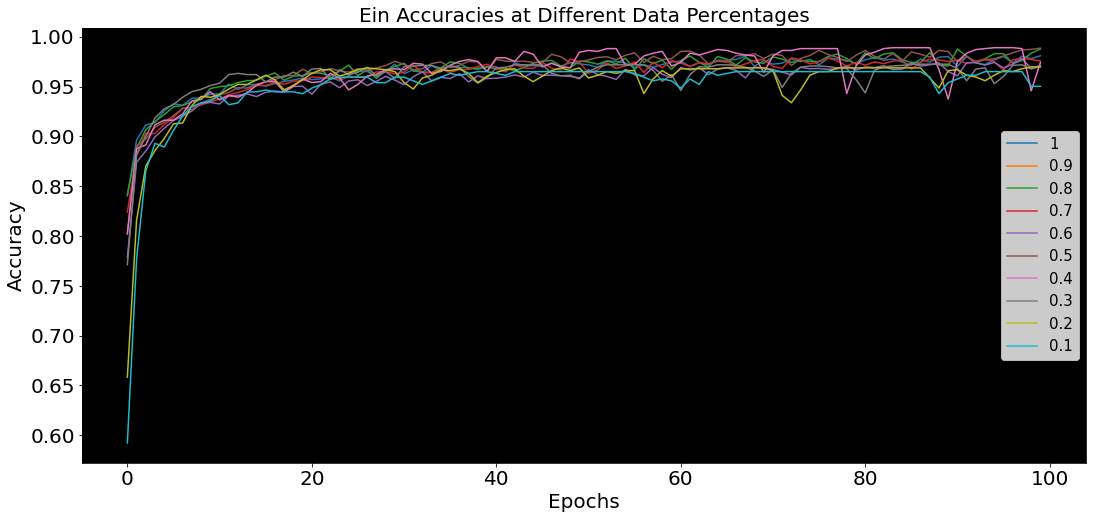

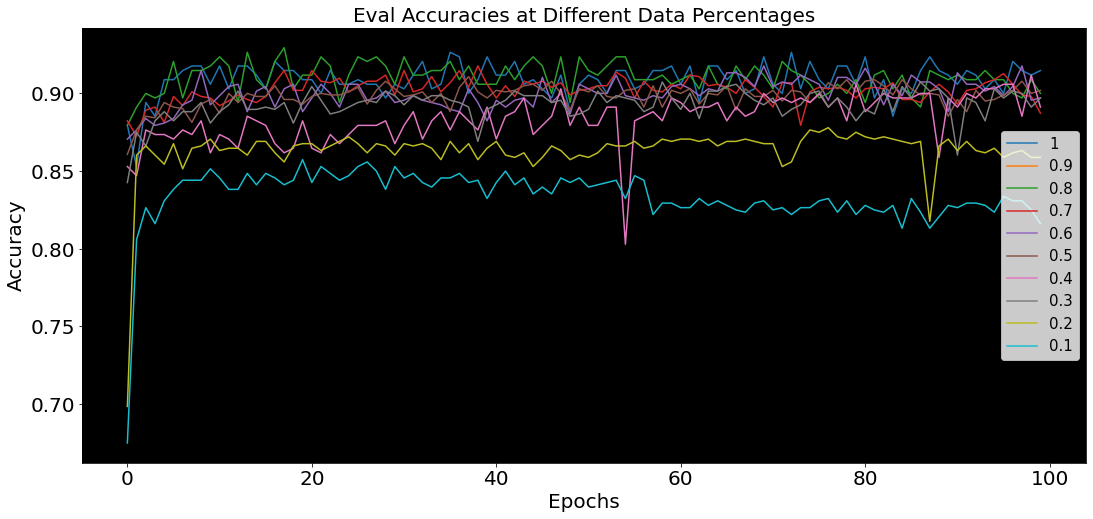

In [55]:

fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
fig1, ax1 = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i in range(len(historys)):
    accuracy = np.zeros(len(historys[0][0].history["accuracy"]))
    valAcc = np.zeros(len(historys[0][0].history["val_accuracy"]))
    for run in historys[i]:
        accuracy += np.array(run.history["accuracy"])
        valAcc += np.array(run.history["val_accuracy"])
    accuracy /= len(historys[i])
    valAcc /= len(historys[i])
    ax.plot(accuracy, label = dataPercents[i])
    ax1.plot(valAcc, label = dataPercents[i])
    
    
ax.legend(loc = 'right', fontsize = 15)
ax.set_title("Ein Accuracies at Different Data Percentages", fontsize = 20)
ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_facecolor("black")
ax1.legend(loc = 'right', fontsize = 15)
ax1.set_title("Eval Accuracies at Different Data Percentages", fontsize = 20)
ax1.set_xlabel("Epochs", fontsize = 20)
ax1.set_ylabel("Accuracy", fontsize = 20)
ax1.set_facecolor("black")

In [59]:
classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)
inputDim = len(labelsTrain)


l1Reg = keras.regularizers.L1(.001)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

historys = []
dataPercents = [1,.9,.8,.7,.6,.5,.4,.3,.2,.1]

for percent in dataPercents:
    currentHist = []
    for run in range(3):
        model1 = tf.keras.models.Sequential([
            tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2)
        ])

        model1.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
        if(percent == 1):
            Xtrain = compoundDataTrain
            Ytrain = classTrain
        else:
            (Xtrain,_,Ytrain,_) = model_selection.train_test_split(compoundDataTrain, classTrain, test_size=(1 - percent))
        Xtrain,_,valData = Transformer.normalizeData(Xtrain, compoundDataTest, compoundDataValidate, newMean=0, newStd=1)    
        print("Percent: ", percent, ". Actual shape: ", np.shape(Xtrain))
        
        tempHist = model1.fit(Xtrain, Ytrain, validation_data = (valData, classVal), epochs=100, batch_size=4)
        if (tempHist.history["accuracy"][-1] > .7 ): #Don't include the run if it was a constant guess
            currentHist.append(tempHist)
    historys.append(currentHist)

Percent:  1 . Actual shape:  (2717, 228)
Epoch 1/100
680/680 [==============================] - 3s 3ms/step - loss: 3.2310 - accuracy: 0.8627 - val_loss: 0.8798 - val_accuracy: 0.8706
Epoch 2/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6778 - accuracy: 0.8999 - val_loss: 0.5596 - val_accuracy: 0.9000
Epoch 3/100
680/680 [==============================] - 2s 3ms/step - loss: 0.5125 - accuracy: 0.9128 - val_loss: 0.4955 - val_accuracy: 0.9059
Epoch 4/100
680/680 [==============================] - 2s 3ms/step - loss: 0.4415 - accuracy: 0.9205 - val_loss: 0.4612 - val_accuracy: 0.9059
Epoch 5/100
680/680 [==============================] - 2s 3ms/step - loss: 0.4083 - accuracy: 0.9242 - val_loss: 0.4243 - val_accuracy: 0.9059
Epoch 6/100
680/680 [==============================] - 2s 3ms/step - loss: 0.3790 - accuracy: 0.9315 - val_loss: 0.4225 - val_accuracy: 0.8941
Epoch 7/100
680/680 [==============================] - 2s 3ms/step - loss: 0.3584 - accuracy: 0.9393 

680/680 [==============================] - 3s 4ms/step - loss: 0.2239 - accuracy: 0.9750 - val_loss: 0.4875 - val_accuracy: 0.8912
Epoch 58/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2198 - accuracy: 0.9787 - val_loss: 0.4709 - val_accuracy: 0.8941
Epoch 59/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2203 - accuracy: 0.9750 - val_loss: 0.5240 - val_accuracy: 0.8912
Epoch 60/100
680/680 [==============================] - 3s 4ms/step - loss: 0.2064 - accuracy: 0.9809 - val_loss: 0.4666 - val_accuracy: 0.9088
Epoch 61/100
680/680 [==============================] - 3s 4ms/step - loss: 0.2289 - accuracy: 0.9742 - val_loss: 0.4298 - val_accuracy: 0.9029
Epoch 62/100
680/680 [==============================] - 3s 4ms/step - loss: 0.1989 - accuracy: 0.9860 - val_loss: 0.4892 - val_accuracy: 0.9206
Epoch 63/100
680/680 [==============================] - 3s 4ms/step - loss: 0.2210 - accuracy: 0.9728 - val_loss: 0.6239 - val_accuracy: 0.8824
Epoch

Epoch 14/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2573 - accuracy: 0.9591 - val_loss: 0.3613 - val_accuracy: 0.9118
Epoch 15/100
680/680 [==============================] - 5s 7ms/step - loss: 0.2589 - accuracy: 0.9566 - val_loss: 0.4012 - val_accuracy: 0.9206
Epoch 16/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2437 - accuracy: 0.9654 - val_loss: 0.3725 - val_accuracy: 0.9324
Epoch 17/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2431 - accuracy: 0.9665 - val_loss: 0.4090 - val_accuracy: 0.9059
Epoch 18/100
680/680 [==============================] - 5s 7ms/step - loss: 0.2411 - accuracy: 0.9617 - val_loss: 0.4148 - val_accuracy: 0.9206
Epoch 19/100
680/680 [==============================] - 4s 5ms/step - loss: 0.2385 - accuracy: 0.9643 - val_loss: 0.4093 - val_accuracy: 0.9147
Epoch 20/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2320 - accuracy: 0.9687 - val_loss: 0.4100 - val_accuracy:

Epoch 71/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2058 - accuracy: 0.9742 - val_loss: 0.4006 - val_accuracy: 0.9088
Epoch 72/100
680/680 [==============================] - 4s 6ms/step - loss: 0.1977 - accuracy: 0.9779 - val_loss: 0.4365 - val_accuracy: 0.9088
Epoch 73/100
680/680 [==============================] - 4s 6ms/step - loss: 0.1959 - accuracy: 0.9768 - val_loss: 0.4219 - val_accuracy: 0.9294
Epoch 74/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2045 - accuracy: 0.9764 - val_loss: 0.4615 - val_accuracy: 0.9147
Epoch 75/100
680/680 [==============================] - 4s 6ms/step - loss: 0.1879 - accuracy: 0.9794 - val_loss: 0.5048 - val_accuracy: 0.9029
Epoch 76/100
680/680 [==============================] - 4s 6ms/step - loss: 0.1905 - accuracy: 0.9790 - val_loss: 0.5228 - val_accuracy: 0.9029
Epoch 77/100
680/680 [==============================] - 4s 6ms/step - loss: 0.1909 - accuracy: 0.9801 - val_loss: 0.4996 - val_accuracy:

680/680 [==============================] - 4s 6ms/step - loss: 0.2545 - accuracy: 0.9510 - val_loss: 0.3863 - val_accuracy: 0.9147
Epoch 28/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2475 - accuracy: 0.9540 - val_loss: 0.4471 - val_accuracy: 0.9118
Epoch 29/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2410 - accuracy: 0.9588 - val_loss: 0.4260 - val_accuracy: 0.9176
Epoch 30/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2676 - accuracy: 0.9499 - val_loss: 0.3927 - val_accuracy: 0.9088
Epoch 31/100
680/680 [==============================] - 5s 7ms/step - loss: 0.2416 - accuracy: 0.9551 - val_loss: 0.3664 - val_accuracy: 0.9176
Epoch 32/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2407 - accuracy: 0.9573 - val_loss: 0.3925 - val_accuracy: 0.9000
Epoch 33/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2423 - accuracy: 0.9584 - val_loss: 0.3822 - val_accuracy: 0.9088
Epoch

Epoch 84/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2180 - accuracy: 0.9658 - val_loss: 0.4846 - val_accuracy: 0.8941
Epoch 85/100
680/680 [==============================] - 5s 7ms/step - loss: 0.2256 - accuracy: 0.9591 - val_loss: 0.5966 - val_accuracy: 0.8882
Epoch 86/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2160 - accuracy: 0.9676 - val_loss: 0.5431 - val_accuracy: 0.8882
Epoch 87/100
680/680 [==============================] - 5s 8ms/step - loss: 0.2129 - accuracy: 0.9669 - val_loss: 0.5048 - val_accuracy: 0.8971
Epoch 88/100
680/680 [==============================] - 5s 7ms/step - loss: 0.2094 - accuracy: 0.9687 - val_loss: 0.5830 - val_accuracy: 0.8882
Epoch 89/100
680/680 [==============================] - 4s 6ms/step - loss: 0.2172 - accuracy: 0.9680 - val_loss: 0.4724 - val_accuracy: 0.9088
Epoch 90/100
680/680 [==============================] - 5s 7ms/step - loss: 0.2226 - accuracy: 0.9650 - val_loss: 0.4144 - val_accuracy:

612/612 [==============================] - 4s 6ms/step - loss: 0.2134 - accuracy: 0.9718 - val_loss: 0.4594 - val_accuracy: 0.9059
Epoch 41/100
612/612 [==============================] - 3s 6ms/step - loss: 0.2154 - accuracy: 0.9730 - val_loss: 0.4417 - val_accuracy: 0.9029
Epoch 42/100
612/612 [==============================] - 4s 7ms/step - loss: 0.1991 - accuracy: 0.9796 - val_loss: 0.4549 - val_accuracy: 0.9147
Epoch 43/100
612/612 [==============================] - 4s 6ms/step - loss: 0.2230 - accuracy: 0.9701 - val_loss: 0.5091 - val_accuracy: 0.8706
Epoch 44/100
612/612 [==============================] - 4s 7ms/step - loss: 0.2254 - accuracy: 0.9697 - val_loss: 0.4092 - val_accuracy: 0.9147
Epoch 45/100
612/612 [==============================] - 4s 6ms/step - loss: 0.2124 - accuracy: 0.9751 - val_loss: 0.4395 - val_accuracy: 0.9088
Epoch 46/100
612/612 [==============================] - 4s 7ms/step - loss: 0.2145 - accuracy: 0.9718 - val_loss: 0.4882 - val_accuracy: 0.9088
Epoch

Epoch 97/100
612/612 [==============================] - 4s 6ms/step - loss: 0.1952 - accuracy: 0.9808 - val_loss: 0.4449 - val_accuracy: 0.9147
Epoch 98/100
612/612 [==============================] - 4s 6ms/step - loss: 0.2022 - accuracy: 0.9775 - val_loss: 0.4420 - val_accuracy: 0.9059
Epoch 99/100
612/612 [==============================] - 4s 6ms/step - loss: 0.1838 - accuracy: 0.9849 - val_loss: 0.5035 - val_accuracy: 0.9029
Epoch 100/100
612/612 [==============================] - 4s 6ms/step - loss: 0.1964 - accuracy: 0.9787 - val_loss: 0.4678 - val_accuracy: 0.9088
Percent:  0.9 . Actual shape:  (2445, 228)
Epoch 1/100
612/612 [==============================] - 5s 7ms/step - loss: 1.3080 - accuracy: 0.8519 - val_loss: 0.5799 - val_accuracy: 0.8765
Epoch 2/100
612/612 [==============================] - 4s 6ms/step - loss: 0.5119 - accuracy: 0.9006 - val_loss: 0.4591 - val_accuracy: 0.8971
Epoch 3/100
612/612 [==============================] - 4s 6ms/step - loss: 0.4112 - accuracy: 

612/612 [==============================] - 4s 7ms/step - loss: 0.2002 - accuracy: 0.9767 - val_loss: 0.4752 - val_accuracy: 0.9059
Epoch 54/100
612/612 [==============================] - 3s 6ms/step - loss: 0.1876 - accuracy: 0.9824 - val_loss: 0.4451 - val_accuracy: 0.9118
Epoch 55/100
612/612 [==============================] - 4s 6ms/step - loss: 0.1942 - accuracy: 0.9779 - val_loss: 0.4506 - val_accuracy: 0.9118
Epoch 56/100
612/612 [==============================] - 4s 7ms/step - loss: 0.1811 - accuracy: 0.9845 - val_loss: 0.4878 - val_accuracy: 0.9147
Epoch 57/100
612/612 [==============================] - 4s 6ms/step - loss: 0.1913 - accuracy: 0.9783 - val_loss: 0.4614 - val_accuracy: 0.9118
Epoch 58/100
612/612 [==============================] - 4s 6ms/step - loss: 0.1842 - accuracy: 0.9812 - val_loss: 0.5249 - val_accuracy: 0.8912
Epoch 59/100
612/612 [==============================] - 3s 6ms/step - loss: 0.1959 - accuracy: 0.9759 - val_loss: 0.4600 - val_accuracy: 0.9147
Epoch

Epoch 10/100
612/612 [==============================] - 4s 6ms/step - loss: 0.2865 - accuracy: 0.9513 - val_loss: 0.3774 - val_accuracy: 0.9088
Epoch 11/100
612/612 [==============================] - 3s 6ms/step - loss: 0.2893 - accuracy: 0.9464 - val_loss: 0.3697 - val_accuracy: 0.9206
Epoch 12/100
612/612 [==============================] - 4s 6ms/step - loss: 0.2759 - accuracy: 0.9509 - val_loss: 0.3737 - val_accuracy: 0.9147
Epoch 13/100
612/612 [==============================] - 4s 6ms/step - loss: 0.2673 - accuracy: 0.9530 - val_loss: 0.4660 - val_accuracy: 0.8912
Epoch 14/100
612/612 [==============================] - 3s 6ms/step - loss: 0.2678 - accuracy: 0.9575 - val_loss: 0.4384 - val_accuracy: 0.9088
Epoch 15/100
612/612 [==============================] - 3s 6ms/step - loss: 0.2599 - accuracy: 0.9587 - val_loss: 0.3809 - val_accuracy: 0.9176
Epoch 16/100
612/612 [==============================] - 4s 6ms/step - loss: 0.2613 - accuracy: 0.9579 - val_loss: 0.3478 - val_accuracy:

Epoch 67/100
612/612 [==============================] - 4s 6ms/step - loss: 0.2111 - accuracy: 0.9730 - val_loss: 0.4749 - val_accuracy: 0.8971
Epoch 68/100
612/612 [==============================] - 4s 6ms/step - loss: 0.1984 - accuracy: 0.9816 - val_loss: 0.5517 - val_accuracy: 0.8824
Epoch 69/100
612/612 [==============================] - 3s 6ms/step - loss: 0.1869 - accuracy: 0.9873 - val_loss: 0.5286 - val_accuracy: 0.9059
Epoch 70/100
612/612 [==============================] - 4s 6ms/step - loss: 0.2102 - accuracy: 0.9763 - val_loss: 0.4863 - val_accuracy: 0.9059
Epoch 71/100
612/612 [==============================] - 4s 6ms/step - loss: 0.1994 - accuracy: 0.9820 - val_loss: 0.5271 - val_accuracy: 0.8941
Epoch 72/100
612/612 [==============================] - 3s 6ms/step - loss: 0.1925 - accuracy: 0.9853 - val_loss: 0.6277 - val_accuracy: 0.8882
Epoch 73/100
612/612 [==============================] - 4s 6ms/step - loss: 0.2124 - accuracy: 0.9796 - val_loss: 0.5068 - val_accuracy:

544/544 [==============================] - 4s 7ms/step - loss: 0.2572 - accuracy: 0.9581 - val_loss: 0.4023 - val_accuracy: 0.9059
Epoch 24/100
544/544 [==============================] - 3s 5ms/step - loss: 0.2429 - accuracy: 0.9659 - val_loss: 0.4198 - val_accuracy: 0.9118
Epoch 25/100
544/544 [==============================] - 3s 6ms/step - loss: 0.2503 - accuracy: 0.9595 - val_loss: 0.4109 - val_accuracy: 0.9088
Epoch 26/100
544/544 [==============================] - 3s 5ms/step - loss: 0.2461 - accuracy: 0.9632 - val_loss: 0.4040 - val_accuracy: 0.9088
Epoch 27/100
544/544 [==============================] - 3s 6ms/step - loss: 0.2505 - accuracy: 0.9609 - val_loss: 0.3815 - val_accuracy: 0.9206
Epoch 28/100
544/544 [==============================] - 3s 5ms/step - loss: 0.2383 - accuracy: 0.9655 - val_loss: 0.4151 - val_accuracy: 0.9118
Epoch 29/100
544/544 [==============================] - 3s 6ms/step - loss: 0.2464 - accuracy: 0.9604 - val_loss: 0.3722 - val_accuracy: 0.9176
Epoch

Epoch 80/100
544/544 [==============================] - 3s 5ms/step - loss: 0.1894 - accuracy: 0.9816 - val_loss: 0.6023 - val_accuracy: 0.8382
Epoch 81/100
544/544 [==============================] - 3s 6ms/step - loss: 0.2243 - accuracy: 0.9701 - val_loss: 0.4067 - val_accuracy: 0.9176
Epoch 82/100
544/544 [==============================] - 3s 6ms/step - loss: 0.1894 - accuracy: 0.9788 - val_loss: 0.4363 - val_accuracy: 0.9000
Epoch 83/100
544/544 [==============================] - 3s 6ms/step - loss: 0.1965 - accuracy: 0.9765 - val_loss: 0.4671 - val_accuracy: 0.9029
Epoch 84/100
544/544 [==============================] - 3s 6ms/step - loss: 0.1891 - accuracy: 0.9830 - val_loss: 0.4880 - val_accuracy: 0.9000
Epoch 85/100
544/544 [==============================] - 3s 5ms/step - loss: 0.1996 - accuracy: 0.9775 - val_loss: 0.4116 - val_accuracy: 0.9147
Epoch 86/100
544/544 [==============================] - 3s 6ms/step - loss: 0.1871 - accuracy: 0.9821 - val_loss: 0.4318 - val_accuracy:

544/544 [==============================] - 3s 5ms/step - loss: 0.2212 - accuracy: 0.9742 - val_loss: 0.4651 - val_accuracy: 0.8912
Epoch 37/100
544/544 [==============================] - 3s 6ms/step - loss: 0.2177 - accuracy: 0.9793 - val_loss: 0.4721 - val_accuracy: 0.9118
Epoch 38/100
544/544 [==============================] - 3s 6ms/step - loss: 0.2237 - accuracy: 0.9765 - val_loss: 0.4575 - val_accuracy: 0.9029
Epoch 39/100
544/544 [==============================] - 3s 6ms/step - loss: 0.2219 - accuracy: 0.9719 - val_loss: 0.4210 - val_accuracy: 0.9088
Epoch 40/100
544/544 [==============================] - 3s 5ms/step - loss: 0.2118 - accuracy: 0.9775 - val_loss: 0.4663 - val_accuracy: 0.9118
Epoch 41/100
544/544 [==============================] - 3s 6ms/step - loss: 0.2097 - accuracy: 0.9788 - val_loss: 0.4833 - val_accuracy: 0.9088
Epoch 42/100
544/544 [==============================] - 5s 9ms/step - loss: 0.2193 - accuracy: 0.9747 - val_loss: 0.4575 - val_accuracy: 0.9088
Epoch

Epoch 93/100
544/544 [==============================] - 3s 6ms/step - loss: 0.1925 - accuracy: 0.9821 - val_loss: 0.4817 - val_accuracy: 0.9118
Epoch 94/100
544/544 [==============================] - 3s 5ms/step - loss: 0.1745 - accuracy: 0.9894 - val_loss: 0.5160 - val_accuracy: 0.9147
Epoch 95/100
544/544 [==============================] - 3s 6ms/step - loss: 0.2047 - accuracy: 0.9784 - val_loss: 0.5867 - val_accuracy: 0.8912
Epoch 96/100
544/544 [==============================] - 3s 6ms/step - loss: 0.2129 - accuracy: 0.9738 - val_loss: 0.4671 - val_accuracy: 0.9235
Epoch 97/100
544/544 [==============================] - 3s 6ms/step - loss: 0.1937 - accuracy: 0.9839 - val_loss: 0.4506 - val_accuracy: 0.9147
Epoch 98/100
544/544 [==============================] - 3s 5ms/step - loss: 0.1812 - accuracy: 0.9857 - val_loss: 0.5799 - val_accuracy: 0.9000
Epoch 99/100
544/544 [==============================] - 4s 7ms/step - loss: 0.1960 - accuracy: 0.9816 - val_loss: 0.4824 - val_accuracy:

544/544 [==============================] - 3s 5ms/step - loss: 0.6889 - accuracy: 0.6245 - val_loss: 0.6950 - val_accuracy: 0.6118
Epoch 50/100
544/544 [==============================] - 3s 6ms/step - loss: 0.6888 - accuracy: 0.6245 - val_loss: 0.6951 - val_accuracy: 0.6118
Epoch 51/100
544/544 [==============================] - 3s 5ms/step - loss: 0.6889 - accuracy: 0.6245 - val_loss: 0.6952 - val_accuracy: 0.6118
Epoch 52/100
544/544 [==============================] - 3s 6ms/step - loss: 0.6890 - accuracy: 0.6245 - val_loss: 0.6951 - val_accuracy: 0.6118
Epoch 53/100
544/544 [==============================] - 4s 7ms/step - loss: 0.6889 - accuracy: 0.6245 - val_loss: 0.6949 - val_accuracy: 0.6118
Epoch 54/100
544/544 [==============================] - 4s 7ms/step - loss: 0.6888 - accuracy: 0.6245 - val_loss: 0.6949 - val_accuracy: 0.6118
Epoch 55/100
544/544 [==============================] - 3s 6ms/step - loss: 0.6888 - accuracy: 0.6245 - val_loss: 0.6950 - val_accuracy: 0.6118
Epoch

Epoch 6/100
476/476 [==============================] - 3s 5ms/step - loss: 0.3546 - accuracy: 0.9363 - val_loss: 0.4123 - val_accuracy: 0.8971
Epoch 7/100
476/476 [==============================] - 3s 7ms/step - loss: 0.3472 - accuracy: 0.9358 - val_loss: 0.4152 - val_accuracy: 0.9088
Epoch 8/100
476/476 [==============================] - 3s 7ms/step - loss: 0.3363 - accuracy: 0.9379 - val_loss: 0.4000 - val_accuracy: 0.9029
Epoch 9/100
476/476 [==============================] - 2s 5ms/step - loss: 0.3283 - accuracy: 0.9411 - val_loss: 0.4130 - val_accuracy: 0.9088
Epoch 10/100
476/476 [==============================] - 3s 7ms/step - loss: 0.3285 - accuracy: 0.9379 - val_loss: 0.4454 - val_accuracy: 0.8882
Epoch 11/100
476/476 [==============================] - 3s 6ms/step - loss: 0.3183 - accuracy: 0.9421 - val_loss: 0.4584 - val_accuracy: 0.8912
Epoch 12/100
476/476 [==============================] - 3s 7ms/step - loss: 0.3097 - accuracy: 0.9458 - val_loss: 0.3880 - val_accuracy: 0.9

Epoch 63/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2560 - accuracy: 0.9548 - val_loss: 0.4001 - val_accuracy: 0.9000
Epoch 64/100
476/476 [==============================] - 2s 4ms/step - loss: 0.2388 - accuracy: 0.9611 - val_loss: 0.4025 - val_accuracy: 0.9059
Epoch 65/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2497 - accuracy: 0.9532 - val_loss: 0.3562 - val_accuracy: 0.9088
Epoch 66/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2462 - accuracy: 0.9584 - val_loss: 0.4014 - val_accuracy: 0.8941
Epoch 67/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2438 - accuracy: 0.9574 - val_loss: 0.3905 - val_accuracy: 0.9147
Epoch 68/100
476/476 [==============================] - 2s 4ms/step - loss: 0.2433 - accuracy: 0.9600 - val_loss: 0.4037 - val_accuracy: 0.8882
Epoch 69/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2448 - accuracy: 0.9616 - val_loss: 0.4059 - val_accuracy:

476/476 [==============================] - 2s 4ms/step - loss: 0.2630 - accuracy: 0.9600 - val_loss: 0.4444 - val_accuracy: 0.9029
Epoch 20/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2585 - accuracy: 0.9642 - val_loss: 0.4629 - val_accuracy: 0.9147
Epoch 21/100
476/476 [==============================] - 2s 4ms/step - loss: 0.2590 - accuracy: 0.9616 - val_loss: 0.4599 - val_accuracy: 0.9059
Epoch 22/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2353 - accuracy: 0.9705 - val_loss: 0.4536 - val_accuracy: 0.9000
Epoch 23/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2429 - accuracy: 0.9684 - val_loss: 0.4405 - val_accuracy: 0.9088
Epoch 24/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2513 - accuracy: 0.9663 - val_loss: 0.4597 - val_accuracy: 0.9000
Epoch 25/100
476/476 [==============================] - 2s 4ms/step - loss: 0.2330 - accuracy: 0.9748 - val_loss: 0.4438 - val_accuracy: 0.9059
Epoch

Epoch 76/100
476/476 [==============================] - 2s 5ms/step - loss: 0.1974 - accuracy: 0.9800 - val_loss: 0.6183 - val_accuracy: 0.8618
Epoch 77/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2324 - accuracy: 0.9716 - val_loss: 0.4835 - val_accuracy: 0.8971
Epoch 78/100
476/476 [==============================] - 2s 5ms/step - loss: 0.1860 - accuracy: 0.9868 - val_loss: 0.5124 - val_accuracy: 0.9029
Epoch 79/100
476/476 [==============================] - 2s 5ms/step - loss: 0.1759 - accuracy: 0.9884 - val_loss: 0.5163 - val_accuracy: 0.9059
Epoch 80/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2013 - accuracy: 0.9811 - val_loss: 0.4956 - val_accuracy: 0.9118
Epoch 81/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2127 - accuracy: 0.9758 - val_loss: 0.5054 - val_accuracy: 0.8882
Epoch 82/100
476/476 [==============================] - 2s 5ms/step - loss: 0.1933 - accuracy: 0.9842 - val_loss: 0.5388 - val_accuracy:

476/476 [==============================] - 2s 4ms/step - loss: 0.2266 - accuracy: 0.9679 - val_loss: 0.3708 - val_accuracy: 0.9029
Epoch 33/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2175 - accuracy: 0.9711 - val_loss: 0.3588 - val_accuracy: 0.9029
Epoch 34/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2192 - accuracy: 0.9705 - val_loss: 0.3864 - val_accuracy: 0.9118
Epoch 35/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2322 - accuracy: 0.9621 - val_loss: 0.3492 - val_accuracy: 0.9147
Epoch 36/100
476/476 [==============================] - 2s 4ms/step - loss: 0.2149 - accuracy: 0.9695 - val_loss: 0.3746 - val_accuracy: 0.9176
Epoch 37/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2266 - accuracy: 0.9679 - val_loss: 0.3753 - val_accuracy: 0.9059
Epoch 38/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2152 - accuracy: 0.9700 - val_loss: 0.3629 - val_accuracy: 0.9088
Epoch

Epoch 89/100
476/476 [==============================] - 2s 5ms/step - loss: 0.1819 - accuracy: 0.9811 - val_loss: 0.4185 - val_accuracy: 0.9176
Epoch 90/100
476/476 [==============================] - 2s 4ms/step - loss: 0.1777 - accuracy: 0.9821 - val_loss: 0.5166 - val_accuracy: 0.8765
Epoch 91/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2008 - accuracy: 0.9742 - val_loss: 0.4923 - val_accuracy: 0.9059
Epoch 92/100
476/476 [==============================] - 2s 5ms/step - loss: 0.1842 - accuracy: 0.9790 - val_loss: 0.4439 - val_accuracy: 0.9206
Epoch 93/100
476/476 [==============================] - 2s 5ms/step - loss: 0.1957 - accuracy: 0.9732 - val_loss: 0.4051 - val_accuracy: 0.9176
Epoch 94/100
476/476 [==============================] - 2s 4ms/step - loss: 0.1818 - accuracy: 0.9784 - val_loss: 0.5676 - val_accuracy: 0.8912
Epoch 95/100
476/476 [==============================] - 2s 5ms/step - loss: 0.1972 - accuracy: 0.9732 - val_loss: 0.4448 - val_accuracy:

408/408 [==============================] - 1s 4ms/step - loss: 0.2243 - accuracy: 0.9650 - val_loss: 0.4135 - val_accuracy: 0.9147
Epoch 46/100
408/408 [==============================] - 2s 5ms/step - loss: 0.2023 - accuracy: 0.9791 - val_loss: 0.4609 - val_accuracy: 0.9206
Epoch 47/100
408/408 [==============================] - 2s 5ms/step - loss: 0.2071 - accuracy: 0.9773 - val_loss: 0.4324 - val_accuracy: 0.9147
Epoch 48/100
408/408 [==============================] - 2s 4ms/step - loss: 0.2100 - accuracy: 0.9742 - val_loss: 0.4902 - val_accuracy: 0.8941
Epoch 49/100
408/408 [==============================] - 2s 5ms/step - loss: 0.1906 - accuracy: 0.9840 - val_loss: 0.4753 - val_accuracy: 0.9059
Epoch 50/100
408/408 [==============================] - 2s 5ms/step - loss: 0.1916 - accuracy: 0.9791 - val_loss: 0.5820 - val_accuracy: 0.9088
Epoch 51/100
408/408 [==============================] - 2s 5ms/step - loss: 0.1994 - accuracy: 0.9773 - val_loss: 0.4646 - val_accuracy: 0.9176
Epoch

408/408 [==============================] - 2s 4ms/step - loss: 1.6626 - accuracy: 0.7945 - val_loss: 0.5847 - val_accuracy: 0.8588
Epoch 2/100
408/408 [==============================] - 2s 5ms/step - loss: 0.5315 - accuracy: 0.8748 - val_loss: 0.4770 - val_accuracy: 0.8735
Epoch 3/100
408/408 [==============================] - 2s 5ms/step - loss: 0.4457 - accuracy: 0.9012 - val_loss: 0.4597 - val_accuracy: 0.8735
Epoch 4/100
408/408 [==============================] - 2s 5ms/step - loss: 0.4090 - accuracy: 0.9135 - val_loss: 0.4438 - val_accuracy: 0.8706
Epoch 5/100
408/408 [==============================] - 2s 5ms/step - loss: 0.3857 - accuracy: 0.9129 - val_loss: 0.4172 - val_accuracy: 0.8853
Epoch 6/100
408/408 [==============================] - 2s 5ms/step - loss: 0.3555 - accuracy: 0.9245 - val_loss: 0.4215 - val_accuracy: 0.8853
Epoch 7/100
408/408 [==============================] - 2s 4ms/step - loss: 0.3391 - accuracy: 0.9288 - val_loss: 0.4442 - val_accuracy: 0.8941
Epoch 8/100

408/408 [==============================] - 2s 4ms/step - loss: 0.1718 - accuracy: 0.9834 - val_loss: 0.6544 - val_accuracy: 0.8971
Epoch 59/100
408/408 [==============================] - 2s 5ms/step - loss: 0.1885 - accuracy: 0.9810 - val_loss: 0.5909 - val_accuracy: 0.9088
Epoch 60/100
408/408 [==============================] - 1s 4ms/step - loss: 0.1732 - accuracy: 0.9840 - val_loss: 0.5747 - val_accuracy: 0.9000
Epoch 61/100
408/408 [==============================] - 2s 4ms/step - loss: 0.1848 - accuracy: 0.9834 - val_loss: 0.6410 - val_accuracy: 0.8941
Epoch 62/100
408/408 [==============================] - 2s 4ms/step - loss: 0.1667 - accuracy: 0.9859 - val_loss: 0.6454 - val_accuracy: 0.8971
Epoch 63/100
408/408 [==============================] - 2s 4ms/step - loss: 0.1662 - accuracy: 0.9847 - val_loss: 0.5628 - val_accuracy: 0.9088
Epoch 64/100
408/408 [==============================] - 2s 5ms/step - loss: 0.1651 - accuracy: 0.9871 - val_loss: 0.5740 - val_accuracy: 0.9000
Epoch

Epoch 15/100
408/408 [==============================] - 2s 5ms/step - loss: 0.3061 - accuracy: 0.9423 - val_loss: 0.4253 - val_accuracy: 0.8971
Epoch 16/100
408/408 [==============================] - 2s 4ms/step - loss: 0.3091 - accuracy: 0.9429 - val_loss: 0.4042 - val_accuracy: 0.9000
Epoch 17/100
408/408 [==============================] - 2s 5ms/step - loss: 0.2869 - accuracy: 0.9472 - val_loss: 0.4948 - val_accuracy: 0.8882
Epoch 18/100
408/408 [==============================] - 2s 5ms/step - loss: 0.3026 - accuracy: 0.9448 - val_loss: 0.3868 - val_accuracy: 0.8941
Epoch 19/100
408/408 [==============================] - 2s 5ms/step - loss: 0.2888 - accuracy: 0.9491 - val_loss: 0.4855 - val_accuracy: 0.8882
Epoch 20/100
408/408 [==============================] - 2s 5ms/step - loss: 0.2757 - accuracy: 0.9497 - val_loss: 0.4955 - val_accuracy: 0.8706
Epoch 21/100
408/408 [==============================] - 2s 5ms/step - loss: 0.2887 - accuracy: 0.9454 - val_loss: 0.4414 - val_accuracy:

Epoch 72/100
408/408 [==============================] - 1s 3ms/step - loss: 0.1999 - accuracy: 0.9767 - val_loss: 0.5172 - val_accuracy: 0.9000
Epoch 73/100
408/408 [==============================] - 2s 5ms/step - loss: 0.1931 - accuracy: 0.9791 - val_loss: 0.6175 - val_accuracy: 0.8941
Epoch 74/100
408/408 [==============================] - 2s 4ms/step - loss: 0.1940 - accuracy: 0.9791 - val_loss: 0.5735 - val_accuracy: 0.8853
Epoch 75/100
408/408 [==============================] - 2s 4ms/step - loss: 0.2105 - accuracy: 0.9742 - val_loss: 0.5540 - val_accuracy: 0.9000
Epoch 76/100
408/408 [==============================] - 2s 4ms/step - loss: 0.2040 - accuracy: 0.9724 - val_loss: 0.5609 - val_accuracy: 0.9000
Epoch 77/100
408/408 [==============================] - 1s 4ms/step - loss: 0.2084 - accuracy: 0.9724 - val_loss: 0.4260 - val_accuracy: 0.9029
Epoch 78/100
408/408 [==============================] - 2s 4ms/step - loss: 0.2077 - accuracy: 0.9699 - val_loss: 0.5181 - val_accuracy:

340/340 [==============================] - 2s 5ms/step - loss: 0.2486 - accuracy: 0.9705 - val_loss: 0.4877 - val_accuracy: 0.9029
Epoch 29/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2254 - accuracy: 0.9809 - val_loss: 0.4264 - val_accuracy: 0.9118
Epoch 30/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1988 - accuracy: 0.9912 - val_loss: 0.4733 - val_accuracy: 0.9059
Epoch 31/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1860 - accuracy: 0.9919 - val_loss: 0.4990 - val_accuracy: 0.9088
Epoch 32/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1972 - accuracy: 0.9904 - val_loss: 0.5370 - val_accuracy: 0.9059
Epoch 33/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2063 - accuracy: 0.9809 - val_loss: 0.4541 - val_accuracy: 0.9235
Epoch 34/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2307 - accuracy: 0.9772 - val_loss: 0.4052 - val_accuracy: 0.9176
Epoch

Epoch 85/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1809 - accuracy: 0.9845 - val_loss: 0.5365 - val_accuracy: 0.8912
Epoch 86/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1624 - accuracy: 0.9867 - val_loss: 0.5153 - val_accuracy: 0.9147
Epoch 87/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1632 - accuracy: 0.9890 - val_loss: 0.5140 - val_accuracy: 0.8941
Epoch 88/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1456 - accuracy: 0.9956 - val_loss: 0.5359 - val_accuracy: 0.9059
Epoch 89/100
340/340 [==============================] - 1s 4ms/step - loss: 0.1435 - accuracy: 0.9934 - val_loss: 0.6009 - val_accuracy: 0.8941
Epoch 90/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1583 - accuracy: 0.9882 - val_loss: 0.5335 - val_accuracy: 0.9059
Epoch 91/100
340/340 [==============================] - 1s 4ms/step - loss: 0.1556 - accuracy: 0.9926 - val_loss: 0.5167 - val_accuracy:

340/340 [==============================] - 1s 3ms/step - loss: 0.2146 - accuracy: 0.9764 - val_loss: 0.5109 - val_accuracy: 0.9029
Epoch 42/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2222 - accuracy: 0.9735 - val_loss: 0.4353 - val_accuracy: 0.9000
Epoch 43/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2037 - accuracy: 0.9801 - val_loss: 0.4975 - val_accuracy: 0.9000
Epoch 44/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1935 - accuracy: 0.9816 - val_loss: 0.5385 - val_accuracy: 0.8971
Epoch 45/100
340/340 [==============================] - 2s 4ms/step - loss: 0.2277 - accuracy: 0.9683 - val_loss: 0.4680 - val_accuracy: 0.9088
Epoch 46/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2398 - accuracy: 0.9691 - val_loss: 0.4629 - val_accuracy: 0.9059
Epoch 47/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2246 - accuracy: 0.9698 - val_loss: 0.4691 - val_accuracy: 0.9059
Epoch

Epoch 98/100
340/340 [==============================] - 1s 3ms/step - loss: 0.1982 - accuracy: 0.9764 - val_loss: 0.5303 - val_accuracy: 0.8941
Epoch 99/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2012 - accuracy: 0.9742 - val_loss: 0.5339 - val_accuracy: 0.9147
Epoch 100/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2192 - accuracy: 0.9676 - val_loss: 0.4792 - val_accuracy: 0.9118
Percent:  0.5 . Actual shape:  (1358, 228)
Epoch 1/100
340/340 [==============================] - 2s 4ms/step - loss: 2.3443 - accuracy: 0.7747 - val_loss: 0.7153 - val_accuracy: 0.8647
Epoch 2/100
340/340 [==============================] - 2s 5ms/step - loss: 0.5943 - accuracy: 0.8785 - val_loss: 0.5234 - val_accuracy: 0.8824
Epoch 3/100
340/340 [==============================] - 2s 5ms/step - loss: 0.4510 - accuracy: 0.9065 - val_loss: 0.4788 - val_accuracy: 0.8912
Epoch 4/100
340/340 [==============================] - 1s 4ms/step - loss: 0.3997 - accuracy: 0

340/340 [==============================] - 2s 5ms/step - loss: 0.1751 - accuracy: 0.9831 - val_loss: 0.5988 - val_accuracy: 0.8853
Epoch 55/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1725 - accuracy: 0.9831 - val_loss: 0.6088 - val_accuracy: 0.8794
Epoch 56/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1698 - accuracy: 0.9831 - val_loss: 0.6527 - val_accuracy: 0.8765
Epoch 57/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2386 - accuracy: 0.9602 - val_loss: 0.7490 - val_accuracy: 0.8618
Epoch 58/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2384 - accuracy: 0.9610 - val_loss: 0.5618 - val_accuracy: 0.8735
Epoch 59/100
340/340 [==============================] - 2s 5ms/step - loss: 0.2107 - accuracy: 0.9691 - val_loss: 0.5043 - val_accuracy: 0.8853
Epoch 60/100
340/340 [==============================] - 2s 5ms/step - loss: 0.1862 - accuracy: 0.9801 - val_loss: 0.5769 - val_accuracy: 0.8853
Epoch

Epoch 11/100
272/272 [==============================] - 1s 5ms/step - loss: 0.3011 - accuracy: 0.9659 - val_loss: 0.5130 - val_accuracy: 0.8971
Epoch 12/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2562 - accuracy: 0.9853 - val_loss: 0.5247 - val_accuracy: 0.8971
Epoch 13/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2525 - accuracy: 0.9797 - val_loss: 0.5536 - val_accuracy: 0.9000
Epoch 14/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2512 - accuracy: 0.9797 - val_loss: 0.5279 - val_accuracy: 0.9000
Epoch 15/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2496 - accuracy: 0.9807 - val_loss: 0.5528 - val_accuracy: 0.9029
Epoch 16/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2567 - accuracy: 0.9788 - val_loss: 0.5690 - val_accuracy: 0.8794
Epoch 17/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2605 - accuracy: 0.9770 - val_loss: 0.5249 - val_accuracy:

Epoch 68/100
272/272 [==============================] - 1s 3ms/step - loss: 0.1449 - accuracy: 0.9954 - val_loss: 0.6739 - val_accuracy: 0.8882
Epoch 69/100
272/272 [==============================] - 1s 3ms/step - loss: 0.1414 - accuracy: 0.9954 - val_loss: 0.6699 - val_accuracy: 0.8853
Epoch 70/100
272/272 [==============================] - 1s 3ms/step - loss: 0.1376 - accuracy: 0.9954 - val_loss: 0.6811 - val_accuracy: 0.8853
Epoch 71/100
272/272 [==============================] - 1s 3ms/step - loss: 0.1341 - accuracy: 0.9954 - val_loss: 0.6683 - val_accuracy: 0.8824
Epoch 72/100
272/272 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.9890 - val_loss: 1.1166 - val_accuracy: 0.7971
Epoch 73/100
272/272 [==============================] - 1s 3ms/step - loss: 0.2989 - accuracy: 0.9475 - val_loss: 0.4803 - val_accuracy: 0.8912
Epoch 74/100
272/272 [==============================] - 1s 3ms/step - loss: 0.2069 - accuracy: 0.9742 - val_loss: 0.5418 - val_accuracy:

272/272 [==============================] - 1s 5ms/step - loss: 0.2691 - accuracy: 0.9484 - val_loss: 0.4292 - val_accuracy: 0.8941
Epoch 25/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2724 - accuracy: 0.9448 - val_loss: 0.4233 - val_accuracy: 0.9029
Epoch 26/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2791 - accuracy: 0.9411 - val_loss: 0.4231 - val_accuracy: 0.9029
Epoch 27/100
272/272 [==============================] - 1s 4ms/step - loss: 0.2660 - accuracy: 0.9457 - val_loss: 0.4490 - val_accuracy: 0.8882
Epoch 28/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2548 - accuracy: 0.9512 - val_loss: 0.4713 - val_accuracy: 0.9000
Epoch 29/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2535 - accuracy: 0.9512 - val_loss: 0.4567 - val_accuracy: 0.8971
Epoch 30/100
272/272 [==============================] - 1s 3ms/step - loss: 0.2452 - accuracy: 0.9530 - val_loss: 0.4613 - val_accuracy: 0.8882
Epoch

Epoch 81/100
272/272 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.9843 - val_loss: 0.4997 - val_accuracy: 0.9206
Epoch 82/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1885 - accuracy: 0.9751 - val_loss: 0.4229 - val_accuracy: 0.9000
Epoch 83/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1763 - accuracy: 0.9797 - val_loss: 0.4067 - val_accuracy: 0.9235
Epoch 84/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1939 - accuracy: 0.9742 - val_loss: 0.4461 - val_accuracy: 0.9176
Epoch 85/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1801 - accuracy: 0.9779 - val_loss: 0.5246 - val_accuracy: 0.9059
Epoch 86/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1621 - accuracy: 0.9853 - val_loss: 0.5210 - val_accuracy: 0.8912
Epoch 87/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1554 - accuracy: 0.9862 - val_loss: 0.5140 - val_accuracy:

272/272 [==============================] - 1s 5ms/step - loss: 0.1761 - accuracy: 0.9890 - val_loss: 0.6617 - val_accuracy: 0.8853
Epoch 38/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2623 - accuracy: 0.9669 - val_loss: 0.4570 - val_accuracy: 0.9118
Epoch 39/100
272/272 [==============================] - 1s 3ms/step - loss: 0.1762 - accuracy: 0.9945 - val_loss: 0.5420 - val_accuracy: 0.9118
Epoch 40/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1606 - accuracy: 0.9991 - val_loss: 0.5755 - val_accuracy: 0.9000
Epoch 41/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1680 - accuracy: 0.9954 - val_loss: 0.5767 - val_accuracy: 0.9029
Epoch 42/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1866 - accuracy: 0.9853 - val_loss: 0.6424 - val_accuracy: 0.8559
Epoch 43/100
272/272 [==============================] - 1s 5ms/step - loss: 0.2309 - accuracy: 0.9715 - val_loss: 0.5130 - val_accuracy: 0.8941
Epoch

Epoch 94/100
272/272 [==============================] - 1s 4ms/step - loss: 0.1658 - accuracy: 0.9880 - val_loss: 0.6074 - val_accuracy: 0.8765
Epoch 95/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1425 - accuracy: 0.9982 - val_loss: 0.6091 - val_accuracy: 0.8912
Epoch 96/100
272/272 [==============================] - 1s 3ms/step - loss: 0.1475 - accuracy: 0.9917 - val_loss: 0.5372 - val_accuracy: 0.9118
Epoch 97/100
272/272 [==============================] - 1s 4ms/step - loss: 0.1411 - accuracy: 0.9972 - val_loss: 0.6171 - val_accuracy: 0.8941
Epoch 98/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1250 - accuracy: 1.0000 - val_loss: 0.6062 - val_accuracy: 0.9000
Epoch 99/100
272/272 [==============================] - 1s 4ms/step - loss: 0.1205 - accuracy: 1.0000 - val_loss: 0.6074 - val_accuracy: 0.9000
Epoch 100/100
272/272 [==============================] - 1s 5ms/step - loss: 0.1171 - accuracy: 1.0000 - val_loss: 0.6181 - val_accuracy

204/204 [==============================] - 1s 4ms/step - loss: 0.2473 - accuracy: 0.9558 - val_loss: 0.4367 - val_accuracy: 0.8912
Epoch 51/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2323 - accuracy: 0.9620 - val_loss: 0.4559 - val_accuracy: 0.9029
Epoch 52/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2278 - accuracy: 0.9632 - val_loss: 0.4280 - val_accuracy: 0.8971
Epoch 53/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2242 - accuracy: 0.9632 - val_loss: 0.4265 - val_accuracy: 0.8971
Epoch 54/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2222 - accuracy: 0.9632 - val_loss: 0.4276 - val_accuracy: 0.9000
Epoch 55/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2204 - accuracy: 0.9632 - val_loss: 0.4157 - val_accuracy: 0.8971
Epoch 56/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2196 - accuracy: 0.9632 - val_loss: 0.4453 - val_accuracy: 0.9000
Epoch

Epoch 7/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6907 - accuracy: 0.6344 - val_loss: 0.7014 - val_accuracy: 0.6118
Epoch 8/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6889 - accuracy: 0.6344 - val_loss: 0.6999 - val_accuracy: 0.6118
Epoch 9/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6877 - accuracy: 0.6344 - val_loss: 0.6991 - val_accuracy: 0.6118
Epoch 10/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6869 - accuracy: 0.6344 - val_loss: 0.6979 - val_accuracy: 0.6118
Epoch 11/100
204/204 [==============================] - 1s 4ms/step - loss: 0.6859 - accuracy: 0.6344 - val_loss: 0.6978 - val_accuracy: 0.6118
Epoch 12/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6854 - accuracy: 0.6344 - val_loss: 0.6971 - val_accuracy: 0.6118
Epoch 13/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6848 - accuracy: 0.6344 - val_loss: 0.6968 - val_accuracy: 0.

Epoch 64/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6832 - accuracy: 0.6344 - val_loss: 0.6956 - val_accuracy: 0.6118
Epoch 65/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6834 - accuracy: 0.6344 - val_loss: 0.6956 - val_accuracy: 0.6118
Epoch 66/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6832 - accuracy: 0.6344 - val_loss: 0.6954 - val_accuracy: 0.6118
Epoch 67/100
204/204 [==============================] - 1s 4ms/step - loss: 0.6833 - accuracy: 0.6344 - val_loss: 0.6952 - val_accuracy: 0.6118
Epoch 68/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6833 - accuracy: 0.6344 - val_loss: 0.6955 - val_accuracy: 0.6118
Epoch 69/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6832 - accuracy: 0.6344 - val_loss: 0.6956 - val_accuracy: 0.6118
Epoch 70/100
204/204 [==============================] - 1s 5ms/step - loss: 0.6831 - accuracy: 0.6344 - val_loss: 0.6954 - val_accuracy:

204/204 [==============================] - 1s 5ms/step - loss: 0.2037 - accuracy: 0.9926 - val_loss: 0.5611 - val_accuracy: 0.9029
Epoch 21/100
204/204 [==============================] - 1s 5ms/step - loss: 0.1920 - accuracy: 0.9939 - val_loss: 0.5611 - val_accuracy: 0.9000
Epoch 22/100
204/204 [==============================] - 1s 5ms/step - loss: 0.1838 - accuracy: 0.9939 - val_loss: 0.6133 - val_accuracy: 0.8853
Epoch 23/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2159 - accuracy: 0.9804 - val_loss: 0.7897 - val_accuracy: 0.8588
Epoch 24/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2602 - accuracy: 0.9681 - val_loss: 0.6516 - val_accuracy: 0.8824
Epoch 25/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2586 - accuracy: 0.9730 - val_loss: 0.5481 - val_accuracy: 0.9059
Epoch 26/100
204/204 [==============================] - 1s 5ms/step - loss: 0.2022 - accuracy: 0.9902 - val_loss: 0.5531 - val_accuracy: 0.9118
Epoch

Epoch 77/100
204/204 [==============================] - 1s 3ms/step - loss: 0.1324 - accuracy: 0.9988 - val_loss: 0.5470 - val_accuracy: 0.9029
Epoch 78/100
204/204 [==============================] - 1s 4ms/step - loss: 0.1264 - accuracy: 0.9988 - val_loss: 0.5608 - val_accuracy: 0.9000
Epoch 79/100
204/204 [==============================] - 1s 4ms/step - loss: 0.1230 - accuracy: 0.9988 - val_loss: 0.5657 - val_accuracy: 0.9059
Epoch 80/100
204/204 [==============================] - 1s 5ms/step - loss: 0.1180 - accuracy: 1.0000 - val_loss: 0.5764 - val_accuracy: 0.9088
Epoch 81/100
204/204 [==============================] - 1s 5ms/step - loss: 0.1148 - accuracy: 1.0000 - val_loss: 0.5844 - val_accuracy: 0.9029
Epoch 82/100
204/204 [==============================] - 1s 5ms/step - loss: 0.1115 - accuracy: 1.0000 - val_loss: 0.5783 - val_accuracy: 0.9059
Epoch 83/100
204/204 [==============================] - 1s 5ms/step - loss: 0.1095 - accuracy: 1.0000 - val_loss: 0.5789 - val_accuracy:

136/136 [==============================] - 1s 5ms/step - loss: 0.2060 - accuracy: 0.9742 - val_loss: 0.4593 - val_accuracy: 0.9000
Epoch 34/100
136/136 [==============================] - 1s 5ms/step - loss: 0.2008 - accuracy: 0.9742 - val_loss: 0.4563 - val_accuracy: 0.8971
Epoch 35/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1976 - accuracy: 0.9742 - val_loss: 0.4529 - val_accuracy: 0.9000
Epoch 36/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1948 - accuracy: 0.9742 - val_loss: 0.4440 - val_accuracy: 0.9029
Epoch 37/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1928 - accuracy: 0.9742 - val_loss: 0.4404 - val_accuracy: 0.9029
Epoch 38/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1908 - accuracy: 0.9742 - val_loss: 0.4293 - val_accuracy: 0.9059
Epoch 39/100
136/136 [==============================] - 1s 4ms/step - loss: 0.1890 - accuracy: 0.9742 - val_loss: 0.4391 - val_accuracy: 0.9029
Epoch

Epoch 90/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1972 - accuracy: 0.9595 - val_loss: 0.4457 - val_accuracy: 0.9029
Epoch 91/100
136/136 [==============================] - 1s 4ms/step - loss: 0.1547 - accuracy: 0.9816 - val_loss: 0.5492 - val_accuracy: 0.8794
Epoch 92/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1632 - accuracy: 0.9761 - val_loss: 0.4581 - val_accuracy: 0.9000
Epoch 93/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1498 - accuracy: 0.9816 - val_loss: 0.4496 - val_accuracy: 0.9000
Epoch 94/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1381 - accuracy: 0.9871 - val_loss: 0.4763 - val_accuracy: 0.9059
Epoch 95/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1351 - accuracy: 0.9871 - val_loss: 0.4770 - val_accuracy: 0.9000
Epoch 96/100
136/136 [==============================] - 1s 4ms/step - loss: 0.1337 - accuracy: 0.9871 - val_loss: 0.4904 - val_accuracy:

136/136 [==============================] - 1s 5ms/step - loss: 0.1777 - accuracy: 0.9908 - val_loss: 0.5982 - val_accuracy: 0.8824
Epoch 47/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1673 - accuracy: 0.9926 - val_loss: 0.6970 - val_accuracy: 0.8735
Epoch 48/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1606 - accuracy: 0.9945 - val_loss: 0.6284 - val_accuracy: 0.8824
Epoch 49/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1535 - accuracy: 0.9945 - val_loss: 0.6277 - val_accuracy: 0.8735
Epoch 50/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1835 - accuracy: 0.9834 - val_loss: 0.6290 - val_accuracy: 0.8706
Epoch 51/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1447 - accuracy: 0.9963 - val_loss: 0.6692 - val_accuracy: 0.8706
Epoch 52/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1386 - accuracy: 0.9963 - val_loss: 0.6705 - val_accuracy: 0.8735
Epoch

Epoch 3/100
136/136 [==============================] - 1s 5ms/step - loss: 0.6689 - accuracy: 0.8950 - val_loss: 0.6442 - val_accuracy: 0.8882
Epoch 4/100
136/136 [==============================] - 1s 5ms/step - loss: 0.5538 - accuracy: 0.9116 - val_loss: 0.5629 - val_accuracy: 0.8941
Epoch 5/100
136/136 [==============================] - 1s 5ms/step - loss: 0.4860 - accuracy: 0.9245 - val_loss: 0.5262 - val_accuracy: 0.8941
Epoch 6/100
136/136 [==============================] - 1s 5ms/step - loss: 0.4202 - accuracy: 0.9466 - val_loss: 0.4888 - val_accuracy: 0.8971
Epoch 7/100
136/136 [==============================] - 1s 5ms/step - loss: 0.3916 - accuracy: 0.9448 - val_loss: 0.5029 - val_accuracy: 0.8824
Epoch 8/100
136/136 [==============================] - 1s 5ms/step - loss: 0.3651 - accuracy: 0.9503 - val_loss: 0.4871 - val_accuracy: 0.8912
Epoch 9/100
136/136 [==============================] - 1s 5ms/step - loss: 0.3448 - accuracy: 0.9521 - val_loss: 0.4508 - val_accuracy: 0.8794

Epoch 60/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1794 - accuracy: 0.9779 - val_loss: 0.4196 - val_accuracy: 0.9059
Epoch 61/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1774 - accuracy: 0.9779 - val_loss: 0.4192 - val_accuracy: 0.9088
Epoch 62/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1781 - accuracy: 0.9779 - val_loss: 0.4188 - val_accuracy: 0.8912
Epoch 63/100
136/136 [==============================] - 1s 5ms/step - loss: 0.2633 - accuracy: 0.9429 - val_loss: 0.4051 - val_accuracy: 0.9059
Epoch 64/100
136/136 [==============================] - 1s 5ms/step - loss: 0.2384 - accuracy: 0.9613 - val_loss: 0.5597 - val_accuracy: 0.8647
Epoch 65/100
136/136 [==============================] - 1s 5ms/step - loss: 0.2323 - accuracy: 0.9595 - val_loss: 0.4516 - val_accuracy: 0.8912
Epoch 66/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1853 - accuracy: 0.9816 - val_loss: 0.4889 - val_accuracy:

Epoch 17/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2824 - accuracy: 0.9631 - val_loss: 0.5277 - val_accuracy: 0.8706
Epoch 18/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2778 - accuracy: 0.9631 - val_loss: 0.5205 - val_accuracy: 0.8765
Epoch 19/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2727 - accuracy: 0.9631 - val_loss: 0.5356 - val_accuracy: 0.8735
Epoch 20/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2679 - accuracy: 0.9631 - val_loss: 0.5217 - val_accuracy: 0.8676
Epoch 21/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2636 - accuracy: 0.9631 - val_loss: 0.5159 - val_accuracy: 0.8735
Epoch 22/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2604 - accuracy: 0.9631 - val_loss: 0.5424 - val_accuracy: 0.8647
Epoch 23/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2726 - accuracy: 0.9631 - val_loss: 0.5570 - val_accuracy: 0.8676
Epoch 

Epoch 75/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1359 - accuracy: 0.9889 - val_loss: 0.5260 - val_accuracy: 0.8765
Epoch 76/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1358 - accuracy: 0.9889 - val_loss: 0.5342 - val_accuracy: 0.8824
Epoch 77/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1350 - accuracy: 0.9889 - val_loss: 0.5182 - val_accuracy: 0.8765
Epoch 78/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1352 - accuracy: 0.9889 - val_loss: 0.5597 - val_accuracy: 0.8735
Epoch 79/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1338 - accuracy: 0.9889 - val_loss: 0.5706 - val_accuracy: 0.8765
Epoch 80/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1333 - accuracy: 0.9889 - val_loss: 0.5503 - val_accuracy: 0.8824
Epoch 81/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2007 - accuracy: 0.9668 - val_loss: 0.5896 - val_accuracy: 0.8559
Epoch 

68/68 [==============================] - 0s 6ms/step - loss: 0.4075 - accuracy: 0.9520 - val_loss: 0.5486 - val_accuracy: 0.8882
Epoch 33/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2564 - accuracy: 0.9963 - val_loss: 0.5993 - val_accuracy: 0.8824
Epoch 34/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2059 - accuracy: 0.9963 - val_loss: 0.6752 - val_accuracy: 0.8647
Epoch 35/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1792 - accuracy: 1.0000 - val_loss: 0.6305 - val_accuracy: 0.8824
Epoch 36/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1651 - accuracy: 1.0000 - val_loss: 0.6239 - val_accuracy: 0.8882
Epoch 37/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1570 - accuracy: 1.0000 - val_loss: 0.6249 - val_accuracy: 0.8882
Epoch 38/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1513 - accuracy: 1.0000 - val_loss: 0.6256 - val_accuracy: 0.8912
Epoch 39/100
68/68 

Epoch 90/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0986 - accuracy: 1.0000 - val_loss: 0.6616 - val_accuracy: 0.8676
Epoch 91/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0975 - accuracy: 1.0000 - val_loss: 0.6860 - val_accuracy: 0.8647
Epoch 92/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0969 - accuracy: 1.0000 - val_loss: 0.7096 - val_accuracy: 0.8588
Epoch 93/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0961 - accuracy: 1.0000 - val_loss: 0.7038 - val_accuracy: 0.8588
Epoch 94/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0952 - accuracy: 1.0000 - val_loss: 0.6703 - val_accuracy: 0.8647
Epoch 95/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0946 - accuracy: 1.0000 - val_loss: 0.7122 - val_accuracy: 0.8559
Epoch 96/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0942 - accuracy: 1.0000 - val_loss: 0.6823 - val_accuracy: 0.8676
Epoch 

68/68 [==============================] - 0s 6ms/step - loss: 0.1780 - accuracy: 0.9815 - val_loss: 0.5106 - val_accuracy: 0.8735
Epoch 48/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1803 - accuracy: 0.9815 - val_loss: 0.4646 - val_accuracy: 0.8971
Epoch 49/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2221 - accuracy: 0.9668 - val_loss: 0.6656 - val_accuracy: 0.8647
Epoch 50/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3513 - accuracy: 0.9299 - val_loss: 0.5455 - val_accuracy: 0.8529
Epoch 51/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2534 - accuracy: 0.9594 - val_loss: 0.5192 - val_accuracy: 0.8676
Epoch 52/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2045 - accuracy: 0.9815 - val_loss: 0.5213 - val_accuracy: 0.8735
Epoch 53/100
68/68 [==============================] - 0s 6ms/step - loss: 0.1957 - accuracy: 0.9815 - val_loss: 0.5365 - val_accuracy: 0.8765
Epoch 54/100
68/68 

1  - Acc: 0.9779168168703715
1  - valAcc: 0.9039215644200643
0.9  - Acc: 0.9805044333140055
0.9  - valAcc: 0.906862755616506
0.8  - Acc: 0.9811320602893829
0.8  - valAcc: 0.9117646813392639
0.7  - Acc: 0.9782570799191793
0.7  - valAcc: 0.9019607702891032
0.6  - Acc: 0.9875255425771078
0.6  - valAcc: 0.8990196188290914
0.5  - Acc: 0.9835542440414429
0.5  - valAcc: 0.8941176335016886
0.4  - Acc: 0.994168202082316
0.4  - valAcc: 0.8911764621734619
0.3  - Acc: 0.9791410863399506
0.3  - valAcc: 0.9073529541492462
0.2  - Acc: 0.990791896979014
0.2  - valAcc: 0.8774509827295939
0.1  - Acc: 0.9901598890622457
0.1  - valAcc: 0.8794117569923401


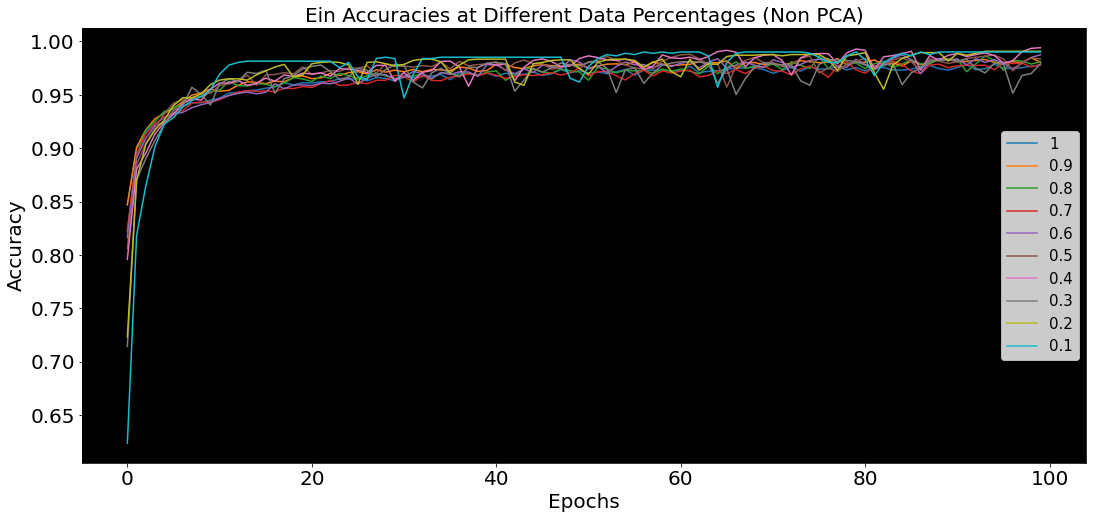

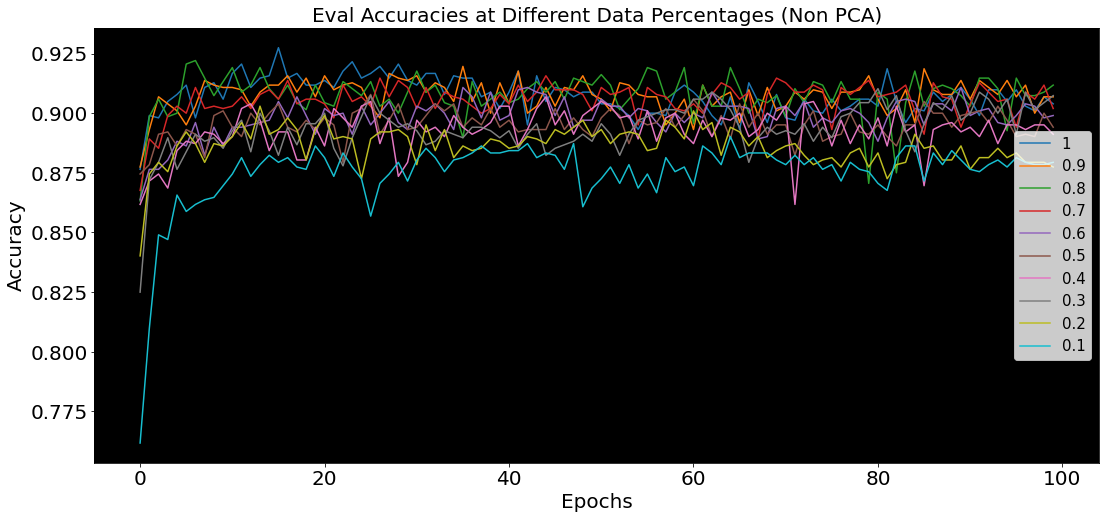

In [63]:

fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
fig1, ax1 = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i in range(len(historys)):
    accuracy = np.zeros(len(historys[0][0].history["accuracy"]))
    valAcc = np.zeros(len(historys[0][0].history["val_accuracy"]))
    for run in historys[i]:
        accuracy += np.array(run.history["accuracy"])
        valAcc += np.array(run.history["val_accuracy"])
    accuracy /= len(historys[i])
    valAcc /= len(historys[i])
    ax.plot(accuracy, label = dataPercents[i])
    ax1.plot(valAcc, label = dataPercents[i])
    print(dataPercents[i], " - Acc:", accuracy[-1])
    print(dataPercents[i], " - valAcc:", valAcc[-1])
    
ax.legend(loc = 'right', fontsize = 15)
ax.set_title("Ein Accuracies at Different Data Percentages (Non PCA)", fontsize = 20)
ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_facecolor("black")
ax1.legend(loc = 'right', fontsize = 15)
ax1.set_title("Eval Accuracies at Different Data Percentages (Non PCA)", fontsize = 20)
ax1.set_xlabel("Epochs", fontsize = 20)
ax1.set_ylabel("Accuracy", fontsize = 20)
ax1.set_facecolor("black")